In [5]:
import pandas as pd
import numpy as np
import os
from scipy.stats import linregress
import matplotlib.pyplot as plt
import glob

In [13]:
#Create a directory for the figures if it does not already exist.
os.makedirs('./DE_Figures', exist_ok=True)

In [7]:
#Read in the cleaned data generated by Data_Cleaning. Save that data as a pandas dataframe, df.
df = pd.read_csv('./Cleaned_Data/V_Full_Data_wPCA.csv')

#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 
#Therefore we should multiply the given cycles by 2 to get the true cycle number.
df["cycle number"] = df["cycle number"].apply(lambda x: 2*x)
df["Cycles Until Fail"] = df["Cycles Until Fail"].apply(lambda x: 2*x)#Correcting cycle number. Original author's state that EIS measurements are taken every other cycle. 

# Adding a classification taget and an additional feature that we can use for regression. 

# Adding a column for the true category (1 if the battery lasts over 200 cycles) (0 otherwise).
to_num=df['label']
to_num=to_num.map({'25C01':1.0,'25C02':0.0,'25C03':0.0,'25C04':0.0,'25C05':0.0,'25C06':0.0,'25C07':0.0,'25C08':0.0,
            '35C01':1.0,'35C02':1.0,'45C01':1.0,'45C02':1.0})
df['category']=to_num

# Adding temperature as a column. 
temdf=df['label']
temdf=temdf.map({'25C01':25.0,'25C02':25.0,'25C03':25.0,'25C04':25.0,'25C05':25.0,'25C06':25.0,'25C07':25.0,
                 '25C08':25.0,'35C01':35.0,'35C02':35.0,'45C01':45.0,'45C02':45.0})
df['temperature']=temdf

df[df['cycle number']==2]


label  cycle number  Capacity/mA.h  Norm_Cap  Cycles Until Fail  \
0     25C01             2      37.202713       1.0                234   
261   25C02             2      35.060836       1.0                 12   
442   25C03             2      36.771703       1.0                164   
644   25C04             2      35.534219       1.0                114   
679   25C05             2      37.210831       1.0                152   
954   25C06             2      35.992184       1.0                120   
1166  25C07             2      35.684646       1.0                 32   
1306  25C08             2      33.943672       1.0                 32   
1343  35C01             2      40.113305       1.0                218   
1670  35C02             2      40.473768       1.0                262   
1988  45C01             2      42.307845       1.0                414   
2287  45C02             2      41.453939       1.0                388   

      20004.453 Re  15829.126 Re  12516.703 Re  9909.4424 Re  7835.48 Re  ...  \
0          0.38470       0.39156       0.39684       0.40341     0.40963  ...   
261        0.27315       0.28005       0.28916       0.29896     0.31009  ...   
442        0.26859       0.27977       0.28738       0.29862     0.31003  ...   
644        0.26546       0.27469       0.28046       0.29147     0.30112  ...   
679        0.34630       0.35399       0.35952       0.36615     0.37339  ...   
954        0.29226       0.29988       0.30750       0.31758     0.32662  ...   
1166       0.30065       0.30717       0.31678       0.32634     0.33815  ...   
1306       0.28914       0.29589       0.30454       0.31619     0.32735  ...   
1343       0.27500       0.28167       0.28649       0.29203     0.29889  ...   
1670       0.47084       0.47585       0.48147       0.48775     0.49372  ...   
1988       1.56984       1.57370       1.57973       1.58275     1.58947  ...   
2287       0.54671       0.55040       0.55430       0.56038     0.56594  ...   

      0.06443 Im  0.05102 Im  0.04042 Im  0.03192 Im  0.02528 Im  0.01999 Im  \
0        0.15473     0.18024     0.21535     0.25411     0.29026     0.32795   
261      0.16948     0.19432     0.23012     0.27316     0.31468     0.35528   
442      0.18334     0.21595     0.25083     0.28522     0.32480     0.37723   
644      0.18886     0.21123     0.24230     0.28393     0.32850     0.37336   
679      0.15592     0.17752     0.20654     0.23916     0.27151     0.31109   
954      0.17112     0.19462     0.22959     0.27546     0.32275     0.36648   
1166     0.17637     0.20248     0.24127     0.28804     0.33312     0.37771   
1306     0.18095     0.20767     0.24267     0.28048     0.32001     0.37131   
1343     0.14148     0.15970     0.18417     0.21406     0.24424     0.27584   
1670     0.13944     0.15736     0.18120     0.21156     0.24130     0.27295   
1988     0.12440     0.14274     0.16139     0.18413     0.21282     0.24432   
2287     0.12735     0.14638     0.16716     0.18935     0.21703     0.25181   

      EIS_PCA_1  EIS_PCA_2  category  temperature  
0     -0.648439   0.135808       1.0         25.0  
261    0.997356  -0.606846       0.0         25.0  
442    1.561054  -0.809891       0.0         25.0  
644    1.061945  -0.751243       0.0         25.0  
679   -1.097987  -0.006821       0.0         25.0  
954    0.706666  -0.459589       0.0         25.0  
1166   1.237057  -0.580435       0.0         25.0  
1306   1.384369  -0.730253       0.0         25.0  
1343  -2.642164  -0.091726       1.0         35.0  
1670  -1.313667   0.634642       1.0         35.0  
1988   5.435422   4.754403       1.0         45.0  
2287  -1.532063   0.970502       1.0         45.0  

[12 rows x 129 columns]

In [8]:
#This function adds a column with just the first cycle EIS response. 
def add_C1_Column(df,EIS):
    C1_dict={}
    for label in df['label'].unique():
        first_row=df[((df['cycle number']==2) & (df['label']==label))]
        C1EIS=first_row.iloc[0][EIS]
        C1_dict[label]=C1EIS
    to_C1=df['label']
    to_C1=to_C1.map(C1_dict)
    col_name='C1_'+str(EIS)
    df[col_name]=to_C1

#This function adds a column with the normalized EIS response. (EIS_i_j/EIS_0_j) for battery j cycle i.
def add_C1_Norm(df,EIS):
    add_C1_Column(df,EIS)
    TAcol_name='Norm_'+str(EIS)
    C1Col_name='C1_'+str(EIS)
    TAcol = (df[EIS]/df[C1Col_name]-1.0)
    df[TAcol_name]=TAcol

In [9]:
#Add The first cycle column and normalized EIS response column from the fuctions defined above.
cols=df.columns.to_list()
for i in range(65,125):
    add_C1_Norm(df,cols[i])

In [10]:
#Generate smaller, balanced dataframes with information from only early cycles. 

#Generate a dataframe with the first 20 cycles only
df_20 = df[(df['cycle number']<=20)]

#Look at data only before the battery fails
noFail_df = df[(df['Cycles Until Fail']>=0)]

#Generate a dataframe with the first cycle only (cycle number 2 is the first cycle)
df_1 = df[(df['cycle number']==2)]

In [11]:
#Function to display a plot quickly.
def plot_CF(mydf,col1,col2):
    plt.scatter(mydf[col1],mydf[col2],c=mydf['category'])
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(col1+' vs. '+col2)
    plt.show()

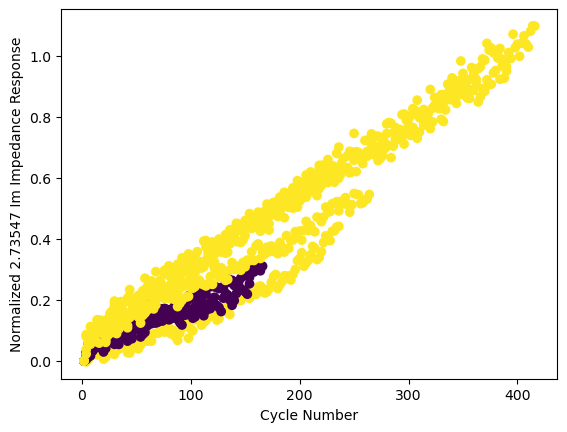

In [17]:
plt.scatter(noFail_df['cycle number'],noFail_df['Norm_2.73547 Im'],c=noFail_df['category'])
plt.ylabel('Normalized 2.73547 Im Impedance Response')
plt.xlabel('Cycle Number')
plt.savefig('./DE_Figures/2HzLinear.png',format='png',dpi=600)
plt.show()

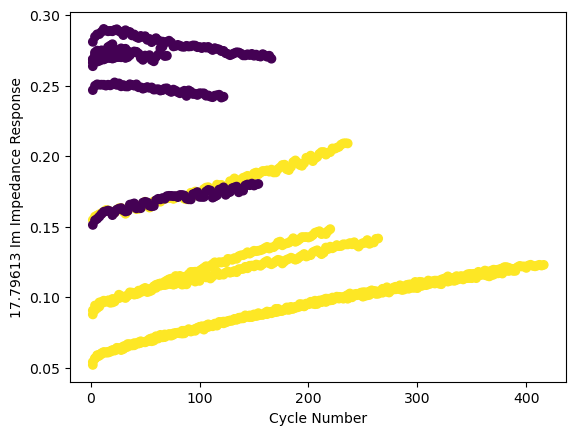

In [18]:
plt.scatter(noFail_df['cycle number'],noFail_df['17.79613 Im'],c=noFail_df['category'])
plt.ylabel('17.79613 Im Impedance Response')
plt.xlabel('Cycle Number')
plt.savefig('./DE_Figures/18HzLinear.png',format='png',dpi=600)
plt.show()

In [8]:
#
#Classification
#

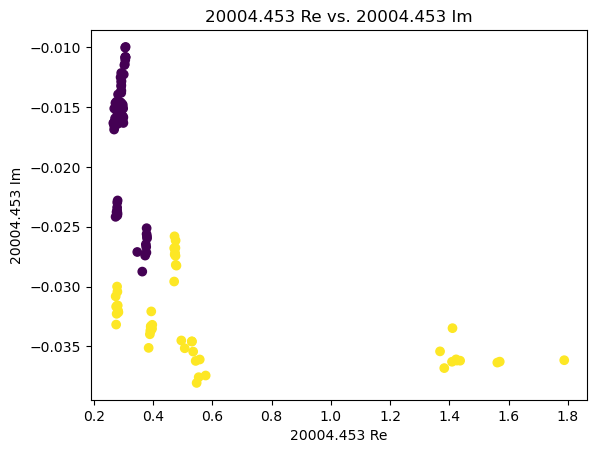

In [9]:
plot_CF(df_20,'20004.453 Re','20004.453 Im')

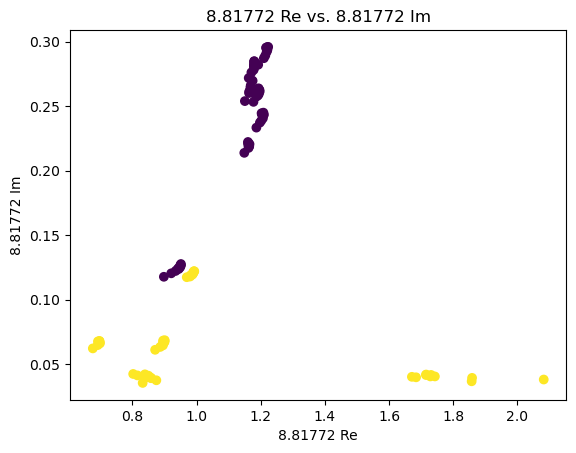

In [32]:
plot_CF(df_20,'8.81772 Re','8.81772 Im')

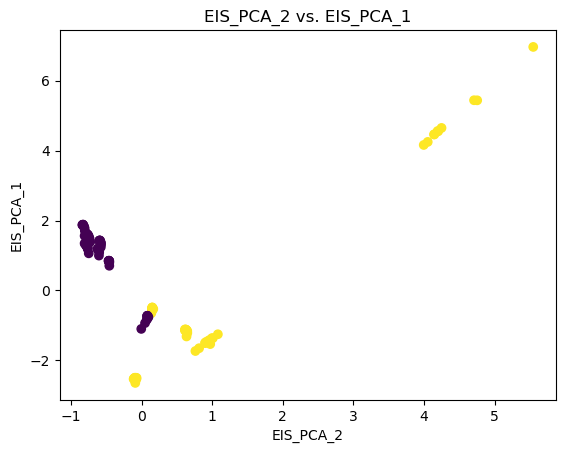

In [33]:
plot_CF(df_20,'EIS_PCA_2','EIS_PCA_1')

In [ ]:
#
#Linear Correlations with Cycle Number
#

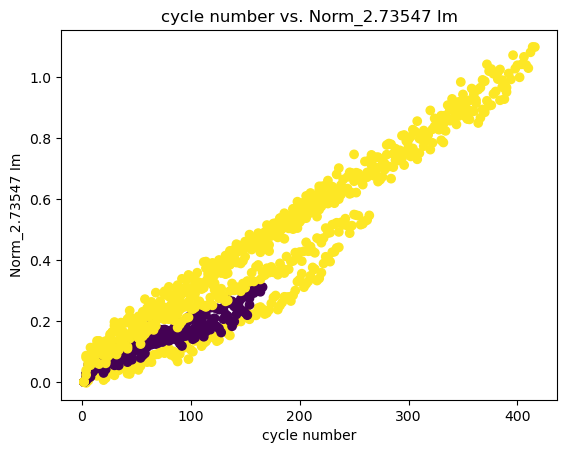

In [15]:
plot_CF(noFail_df,'cycle number','Norm_2.73547 Im')

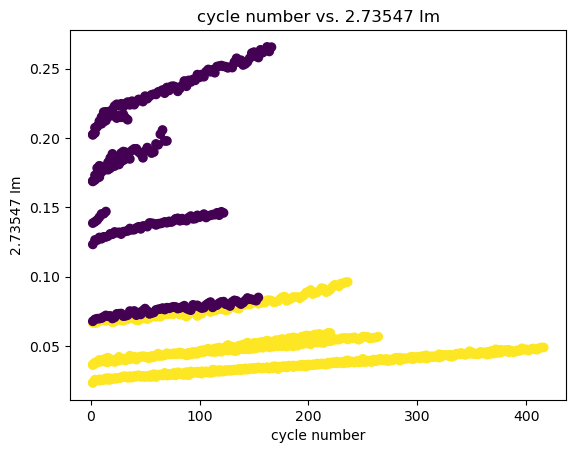

In [16]:
plot_CF(noFail_df,'cycle number','2.73547 Im')

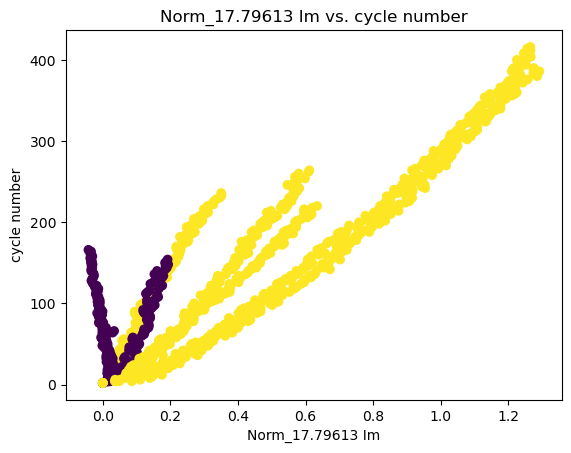

In [12]:
plot_CF(noFail_df,'Norm_17.79613 Im','cycle number')

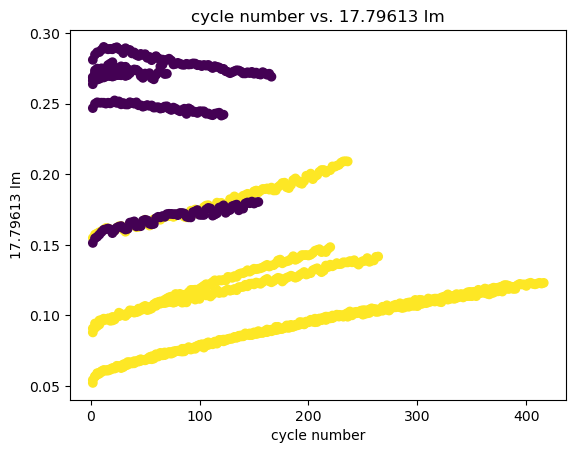

In [14]:
plot_CF(noFail_df,'cycle number','17.79613 Im')

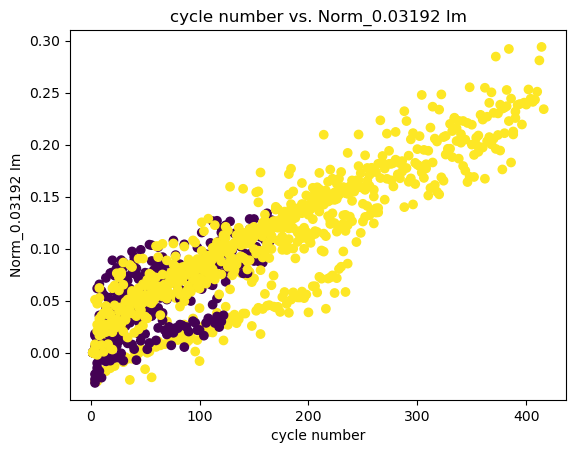

In [23]:
plot_CF(noFail_df,'cycle number','Norm_0.03192 Im')

In [9]:
#
#Linear Correlations with RuL
#

In [76]:
#Find the r^2 for EIS response vs RuL.
def Plot_LR(mydf,col1,col2):
    x=mydf[col1].to_numpy()
    y=mydf[col2].to_numpy()
    slope, intercept, r, p, se = linregress(x, y)
    print('r^2 for linear Regression of '+col1+' vs. '+col2+' is: ')
    print(str(r**2.))
    plt.scatter(mydf[col1],mydf[col2])
    plt.plot(x,intercept+slope*x)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(col1+' vs. '+col2+' With Linear Regression')
    plt.show()

In [77]:
#Function to run linear regression and make plot.
def Return_Lin_r2(mydf,col1,col2):
    x=mydf[col1].to_numpy()
    y=mydf[col2].to_numpy()
    slope, intercept, r, p, se = linregress(x, y)
    return r**2.

r^2 for linear Regression of 8.81772 Im vs. Cycles Until Fail is: 
0.7295935673963517


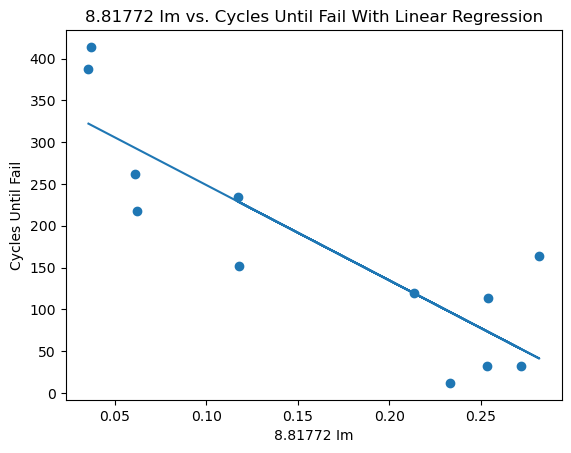

In [78]:
Plot_LR(df_1,'8.81772 Im','Cycles Until Fail')

r^2 for linear Regression of 20004.453 Re vs. Cycles Until Fail is: 
0.504178832079568


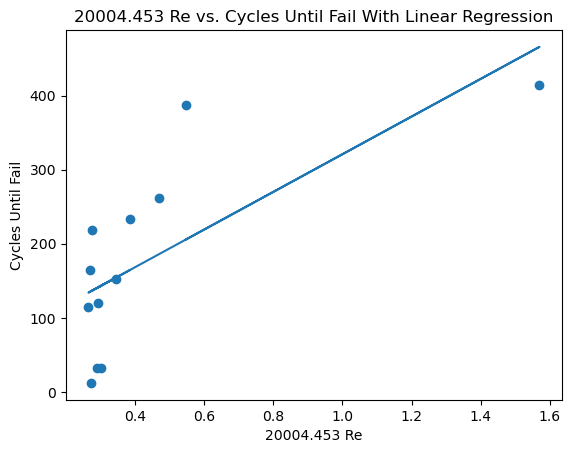

r^2 for linear Regression of 15829.126 Re vs. Cycles Until Fail is: 
0.5028996458973473


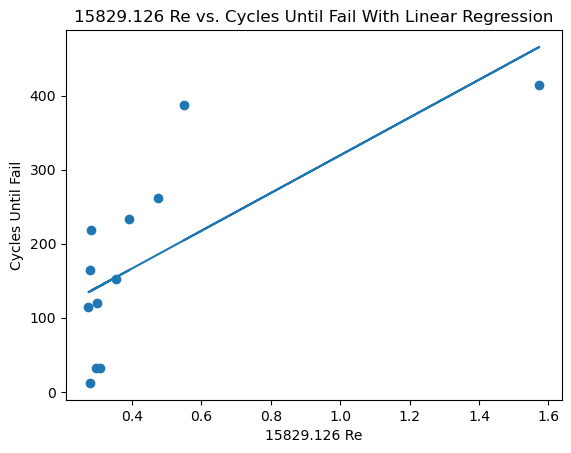

r^2 for linear Regression of 12516.703 Re vs. Cycles Until Fail is: 
0.4985564569146866


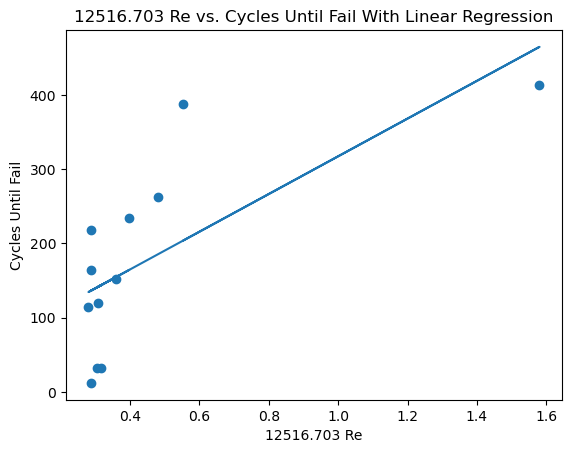

r^2 for linear Regression of 9909.4424 Re vs. Cycles Until Fail is: 
0.494942772515598


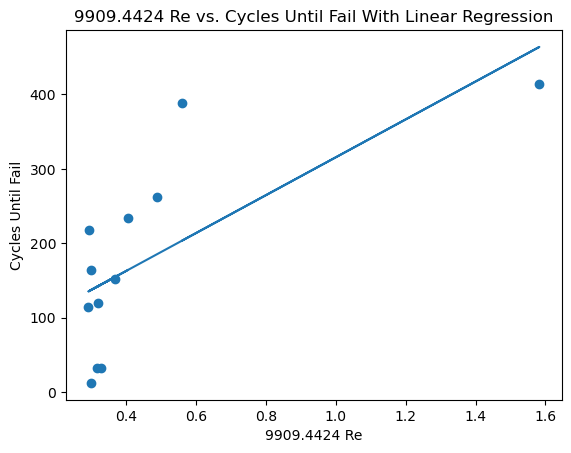

r^2 for linear Regression of 7835.48 Re vs. Cycles Until Fail is: 
0.4898633302002737


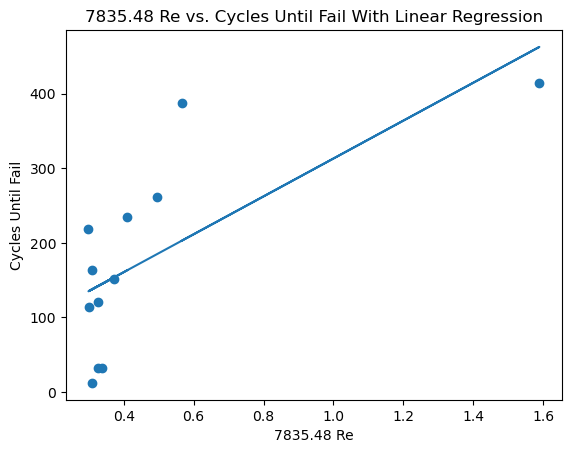

r^2 for linear Regression of 6217.2461 Re vs. Cycles Until Fail is: 
0.48494669348251723


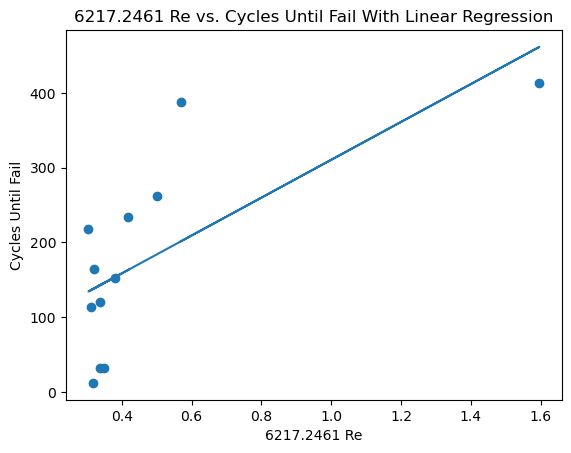

r^2 for linear Regression of 4905.291 Re vs. Cycles Until Fail is: 
0.48019825106331787


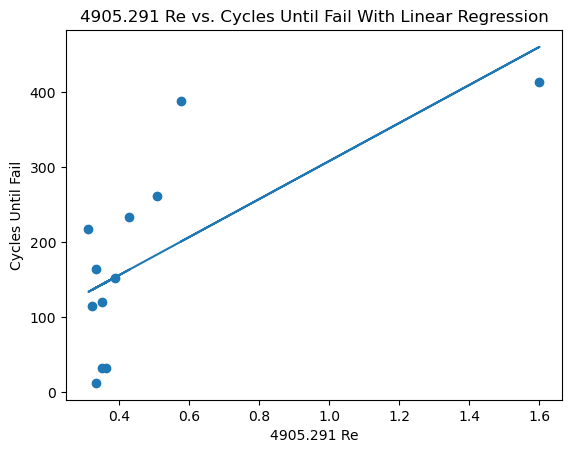

r^2 for linear Regression of 3881.2737 Re vs. Cycles Until Fail is: 
0.47395759712859553


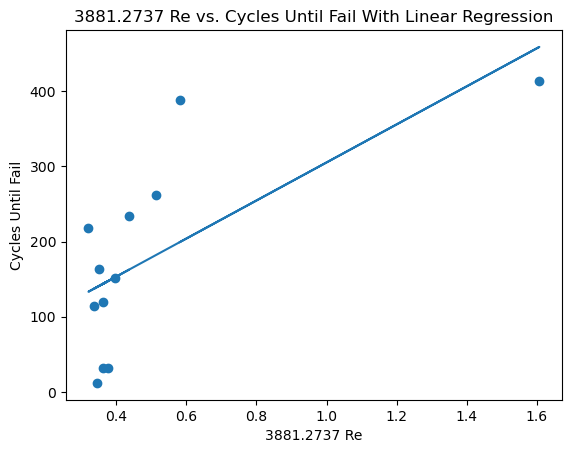

r^2 for linear Regression of 3070.9827 Re vs. Cycles Until Fail is: 
0.46604369500970066


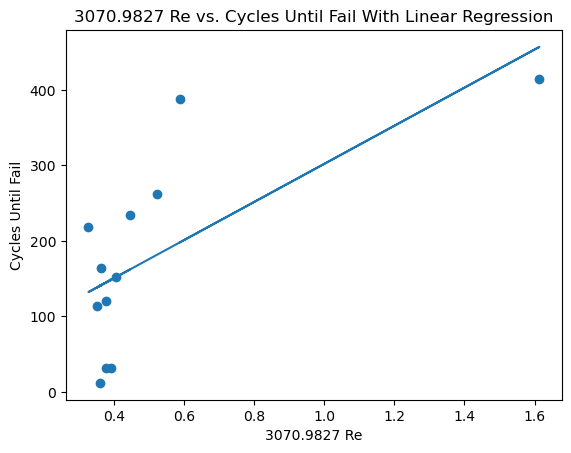

r^2 for linear Regression of 2430.7778 Re vs. Cycles Until Fail is: 
0.4590668761840825


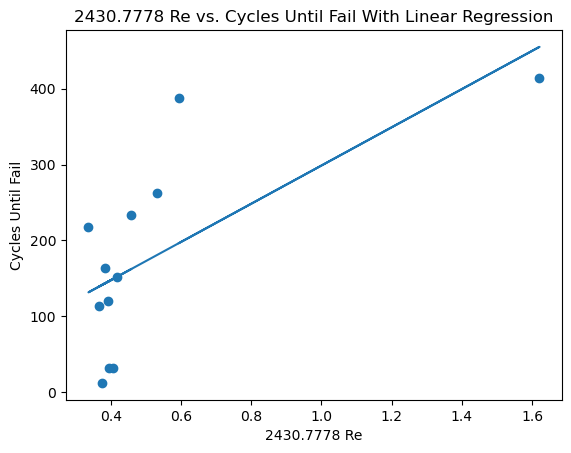

r^2 for linear Regression of 1923.1537 Re vs. Cycles Until Fail is: 
0.4510026836264798


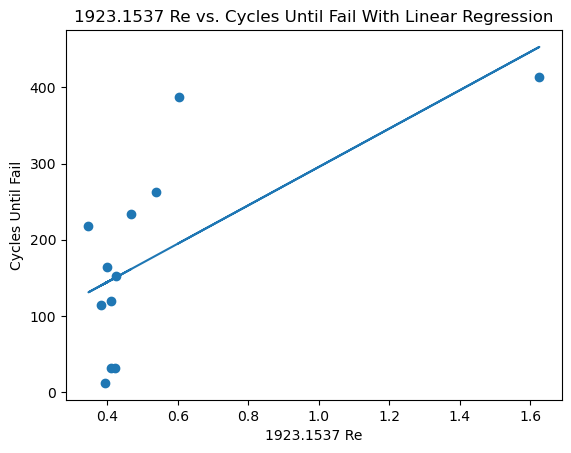

r^2 for linear Regression of 1522.4358 Re vs. Cycles Until Fail is: 
0.44313499009142066


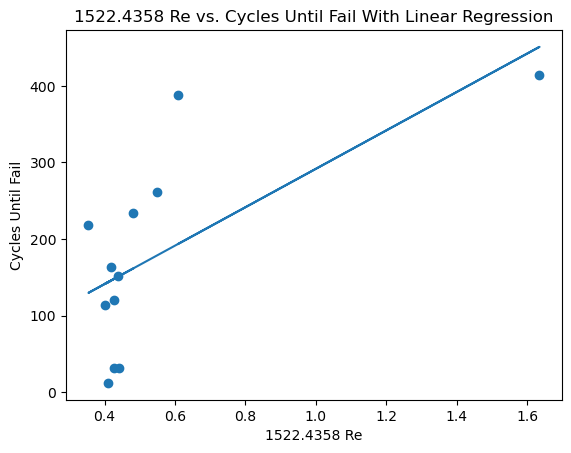

r^2 for linear Regression of 1203.8446 Re vs. Cycles Until Fail is: 
0.431099238450215


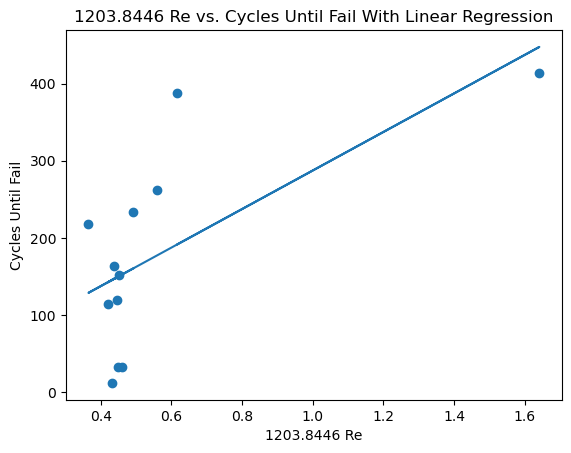

r^2 for linear Regression of 952.86591 Re vs. Cycles Until Fail is: 
0.41875087082438023


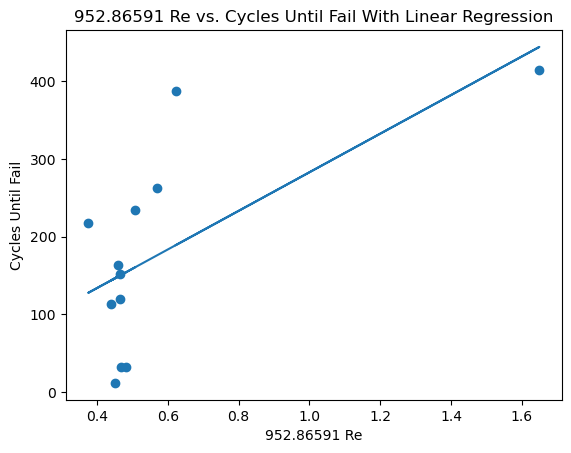

r^2 for linear Regression of 754.27557 Re vs. Cycles Until Fail is: 
0.40863624455332964


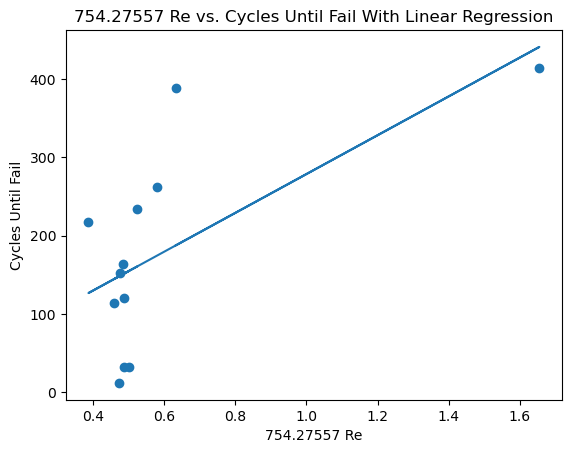

r^2 for linear Regression of 596.71857 Re vs. Cycles Until Fail is: 
0.3935048573921753


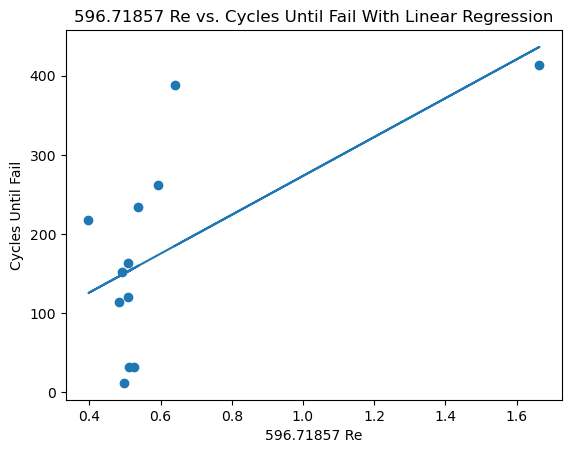

r^2 for linear Regression of 471.96338 Re vs. Cycles Until Fail is: 
0.3786695510677582


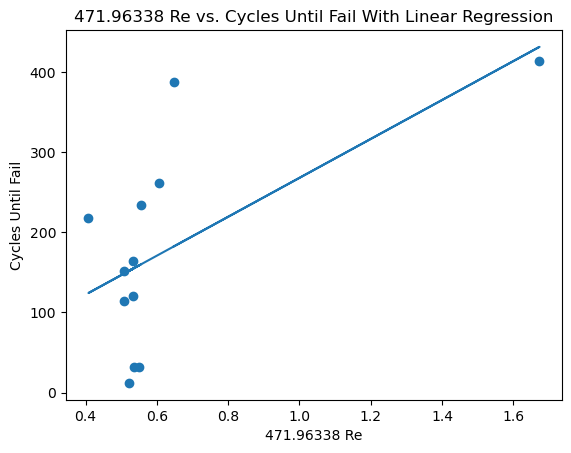

r^2 for linear Regression of 373.20856 Re vs. Cycles Until Fail is: 
0.3619129745897726


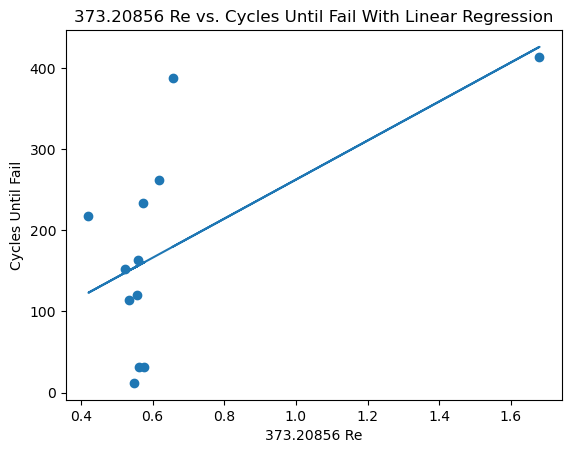

r^2 for linear Regression of 295.47278 Re vs. Cycles Until Fail is: 
0.3456018848821653


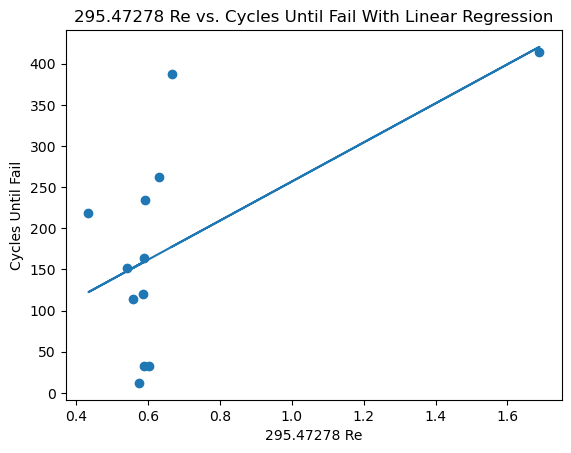

r^2 for linear Regression of 233.87738 Re vs. Cycles Until Fail is: 
0.32652990794460746


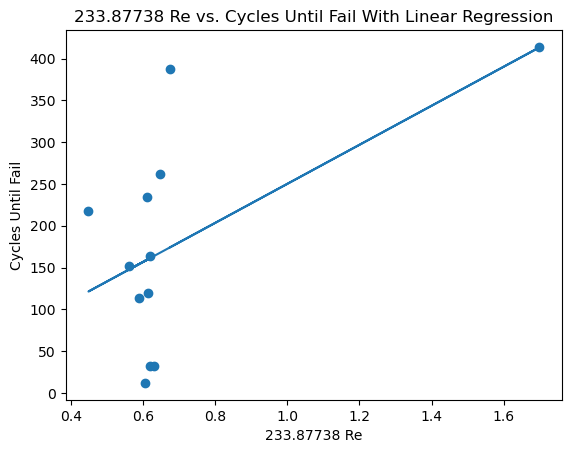

r^2 for linear Regression of 185.05922 Re vs. Cycles Until Fail is: 
0.3055533504148318


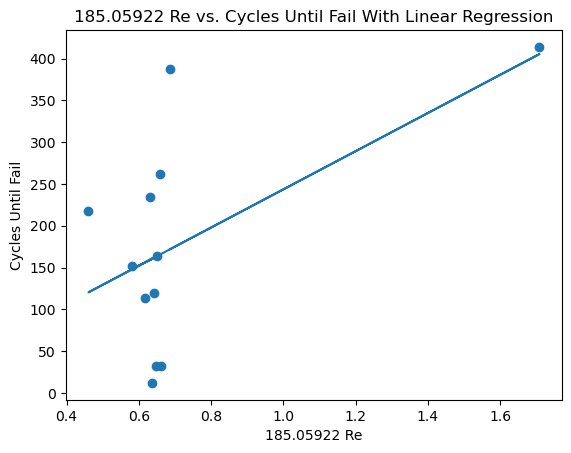

r^2 for linear Regression of 146.35823 Re vs. Cycles Until Fail is: 
0.28310917279610154


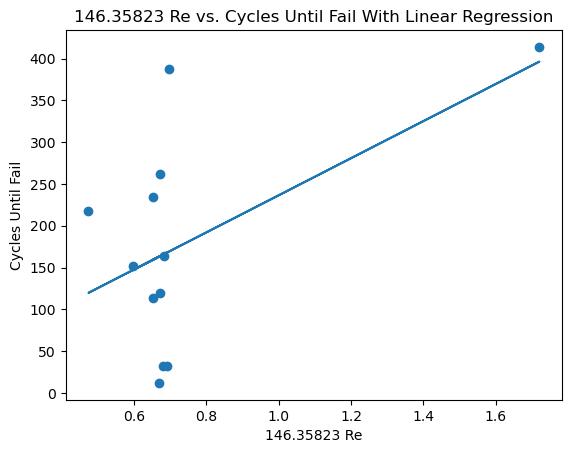

r^2 for linear Regression of 115.77804 Re vs. Cycles Until Fail is: 
0.260925661081358


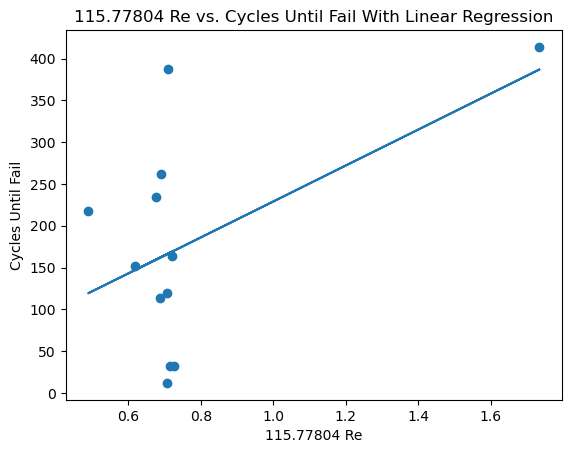

r^2 for linear Regression of 91.6721 Re vs. Cycles Until Fail is: 
0.2353530829242129


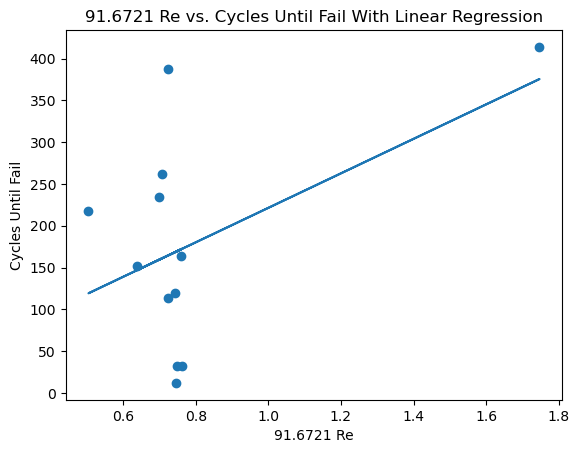

r^2 for linear Regression of 72.51701 Re vs. Cycles Until Fail is: 
0.21266742083232384


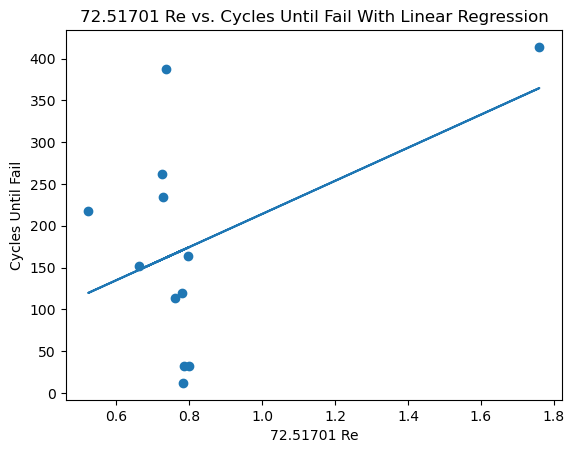

r^2 for linear Regression of 57.36816 Re vs. Cycles Until Fail is: 
0.18933934411876294


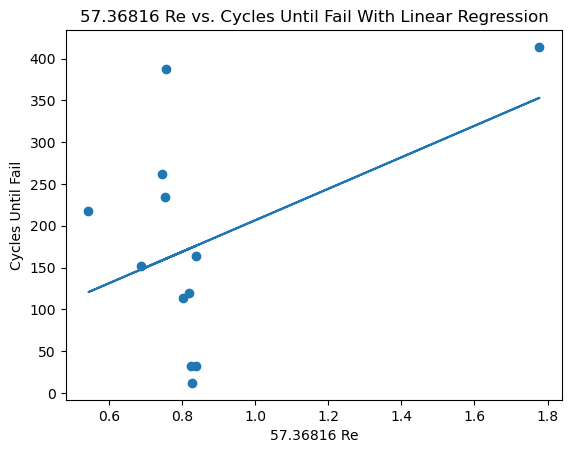

r^2 for linear Regression of 45.3629 Re vs. Cycles Until Fail is: 
0.16495674698747698


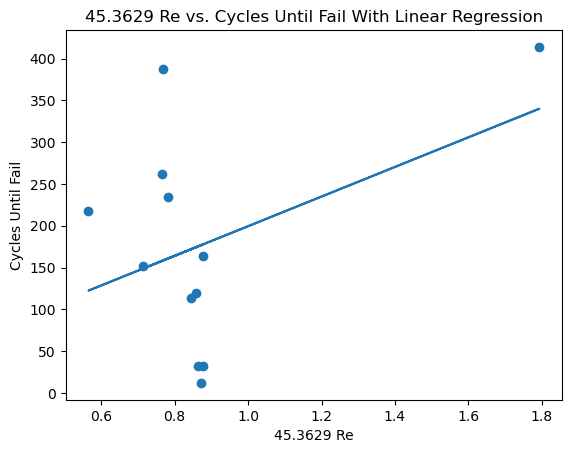

r^2 for linear Regression of 35.93134 Re vs. Cycles Until Fail is: 
0.14196205422463173


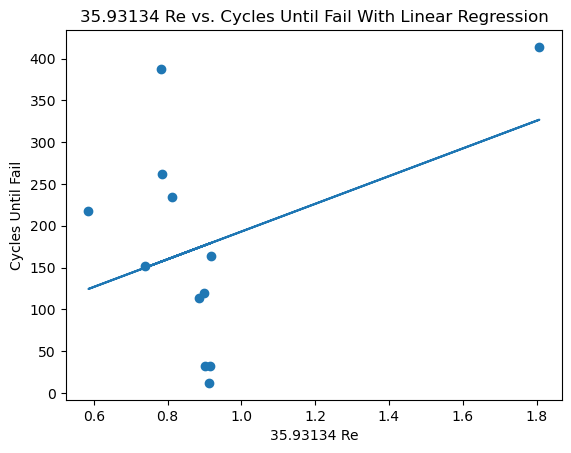

r^2 for linear Regression of 28.40909 Re vs. Cycles Until Fail is: 
0.11681058943123718


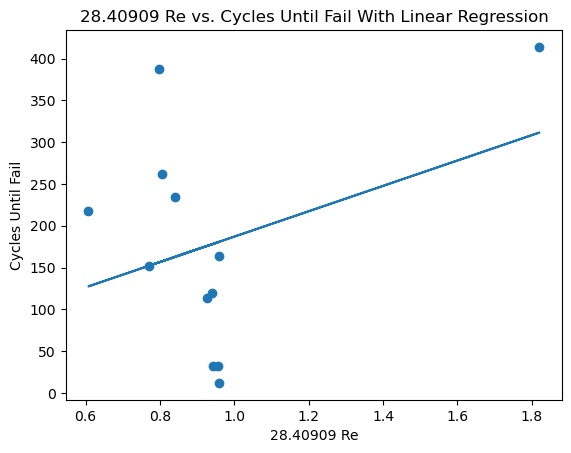

r^2 for linear Regression of 22.48202 Re vs. Cycles Until Fail is: 
0.09181241841959072


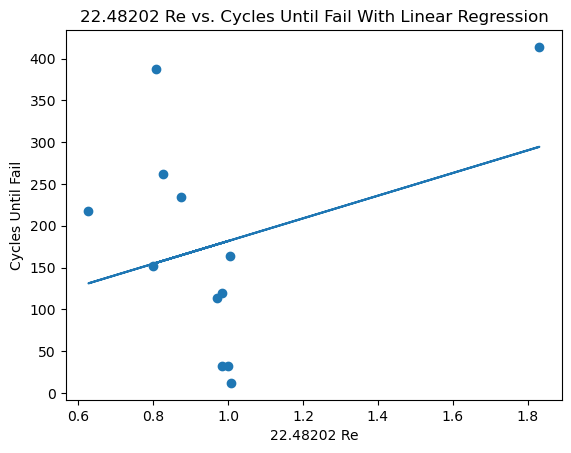

r^2 for linear Regression of 17.79613 Re vs. Cycles Until Fail is: 
0.06747030319634761


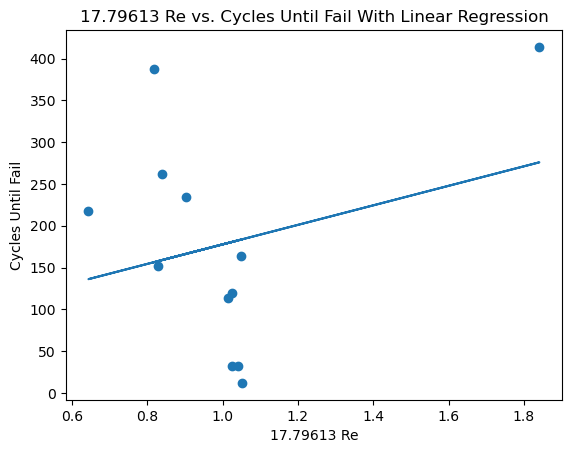

r^2 for linear Regression of 14.06813 Re vs. Cycles Until Fail is: 
0.04352221710056457


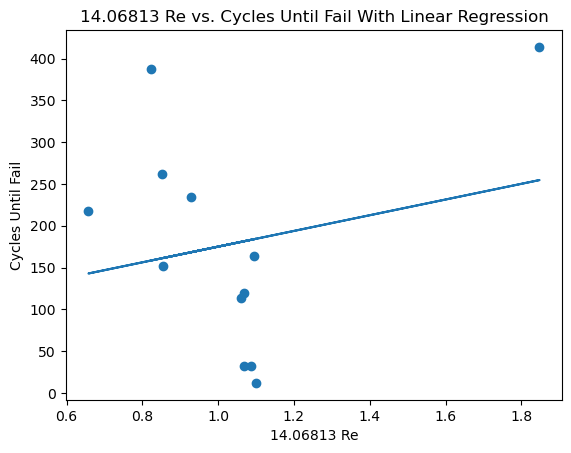

r^2 for linear Regression of 11.1448 Re vs. Cycles Until Fail is: 
0.023693563116711197


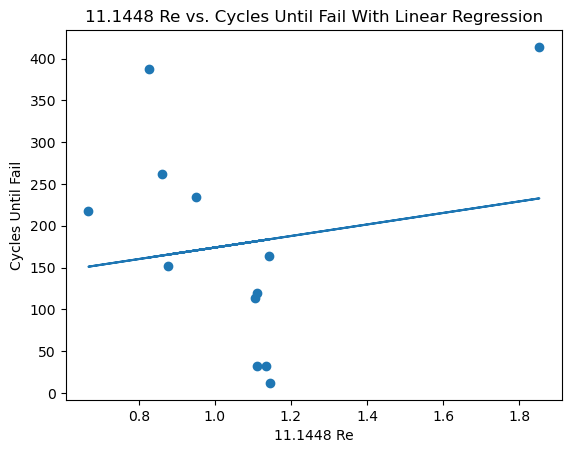

r^2 for linear Regression of 8.81772 Re vs. Cycles Until Fail is: 
0.009671902292608947


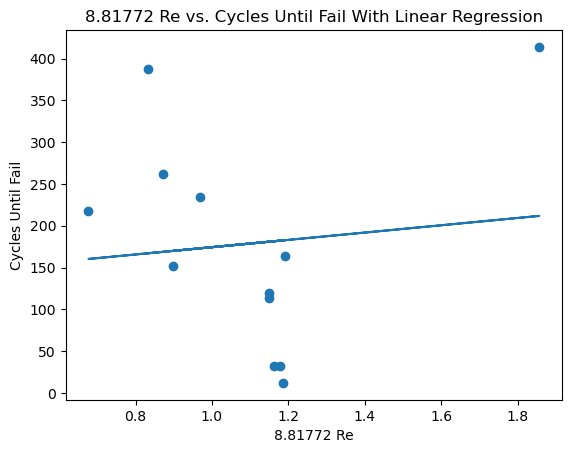

r^2 for linear Regression of 6.97545 Re vs. Cycles Until Fail is: 
0.002238161043307332


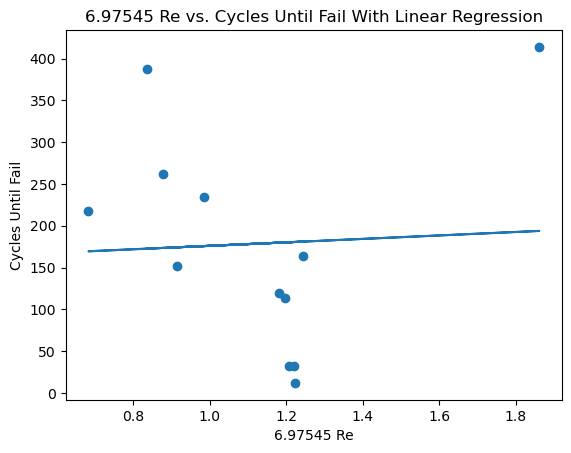

r^2 for linear Regression of 5.5173 Re vs. Cycles Until Fail is: 
2.201138333186535e-05


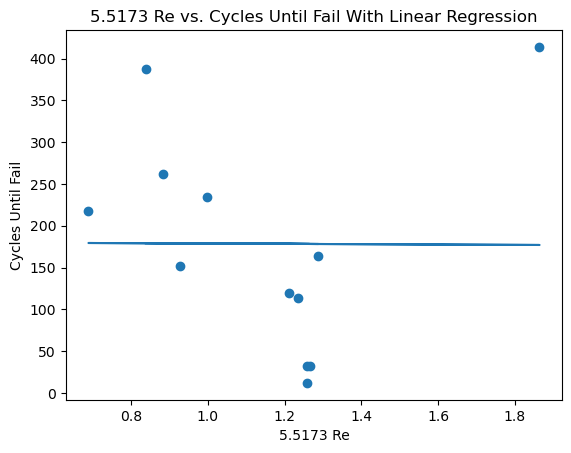

r^2 for linear Regression of 4.36941 Re vs. Cycles Until Fail is: 
0.0019447074421664056


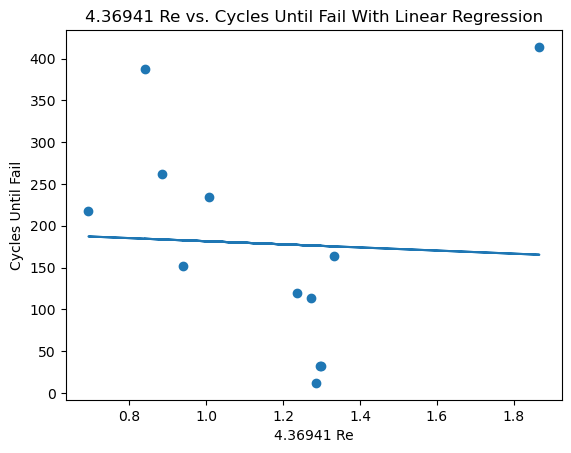

r^2 for linear Regression of 3.45686 Re vs. Cycles Until Fail is: 
0.006393953182923711


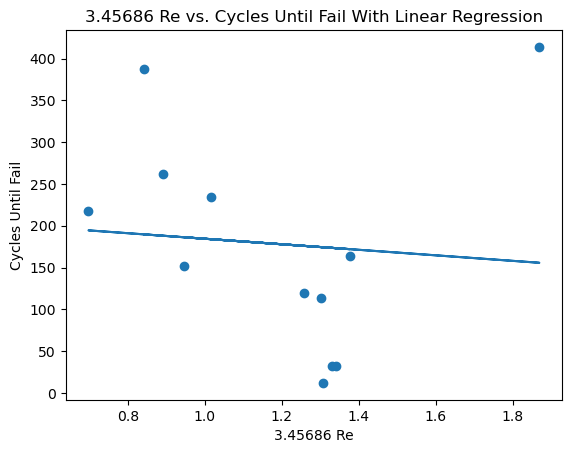

r^2 for linear Regression of 2.73547 Re vs. Cycles Until Fail is: 
0.011523157853545586


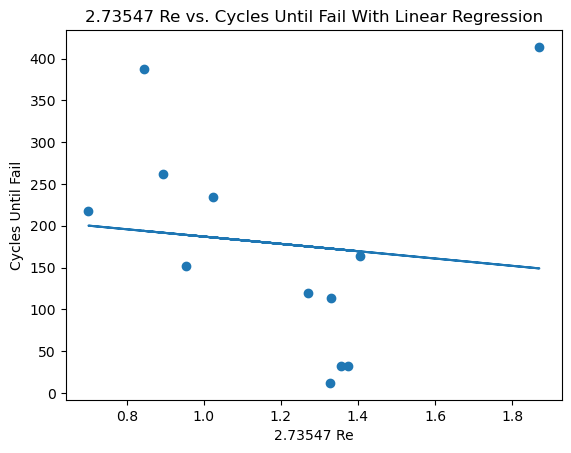

r^2 for linear Regression of 2.16054 Re vs. Cycles Until Fail is: 
0.016388503822235164


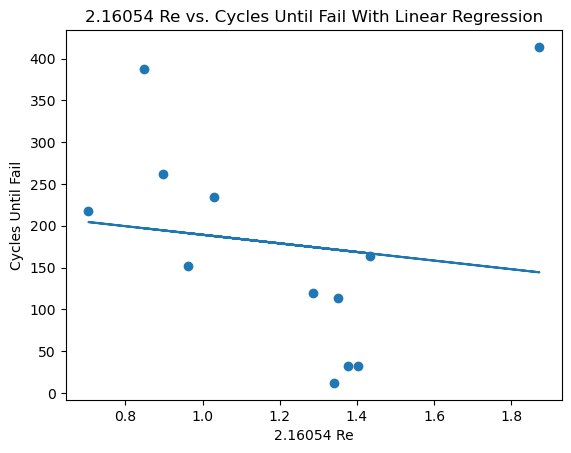

r^2 for linear Regression of 1.70952 Re vs. Cycles Until Fail is: 
0.020688279674234124


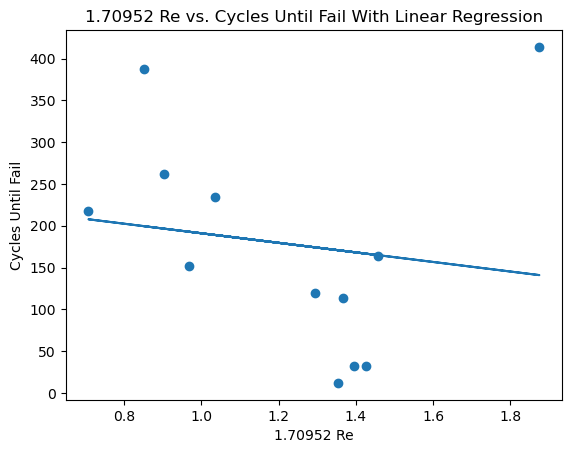

r^2 for linear Regression of 1.35352 Re vs. Cycles Until Fail is: 
0.02471449676747809


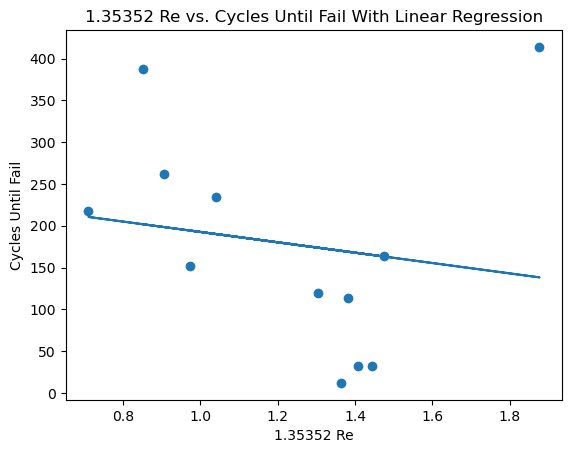

r^2 for linear Regression of 1.07079 Re vs. Cycles Until Fail is: 
0.027842409258801444


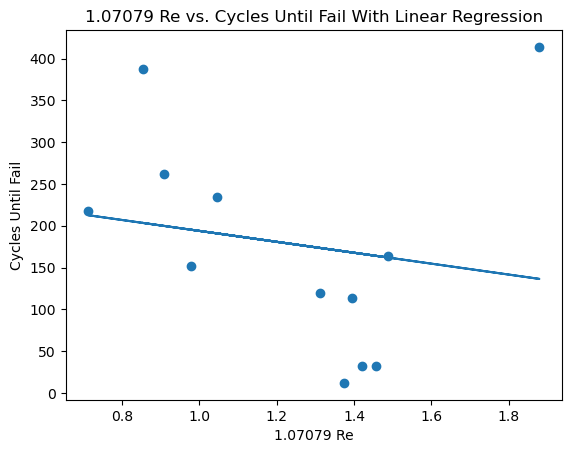

r^2 for linear Regression of 0.84734 Re vs. Cycles Until Fail is: 
0.030177605624966193


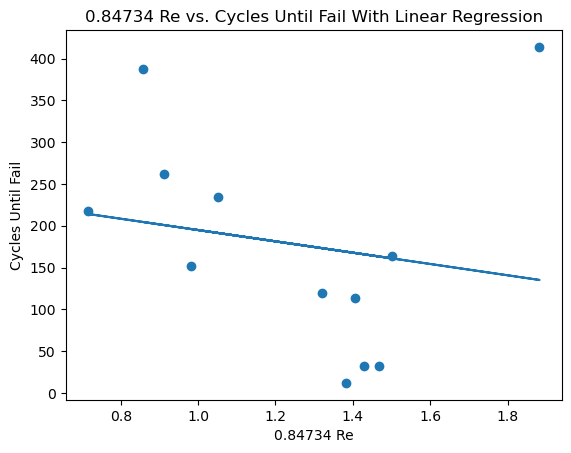

r^2 for linear Regression of 0.67072 Re vs. Cycles Until Fail is: 
0.03238309067804608


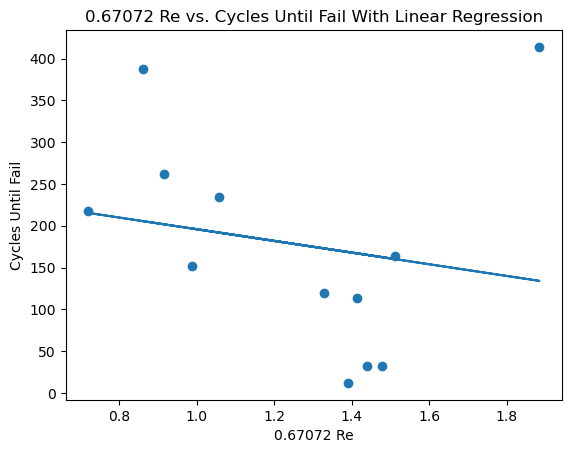

r^2 for linear Regression of 0.53067 Re vs. Cycles Until Fail is: 
0.03464897979986345


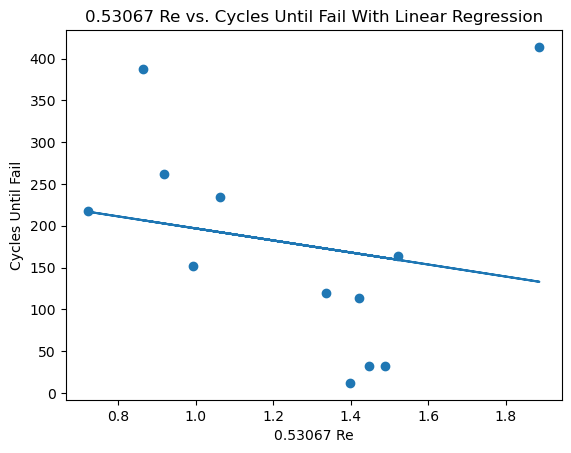

r^2 for linear Regression of 0.41976 Re vs. Cycles Until Fail is: 
0.03671208416293221


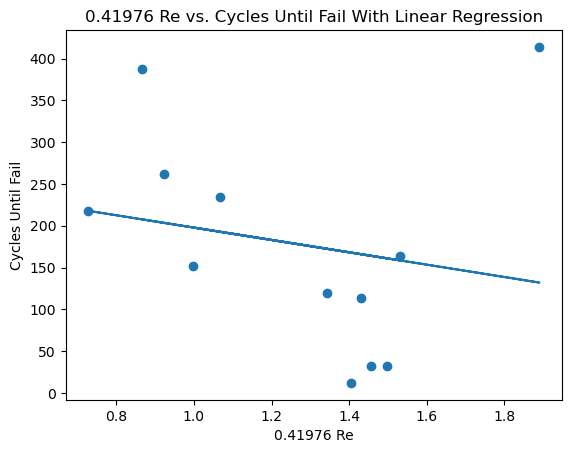

r^2 for linear Regression of 0.33183 Re vs. Cycles Until Fail is: 
0.03787976936248134


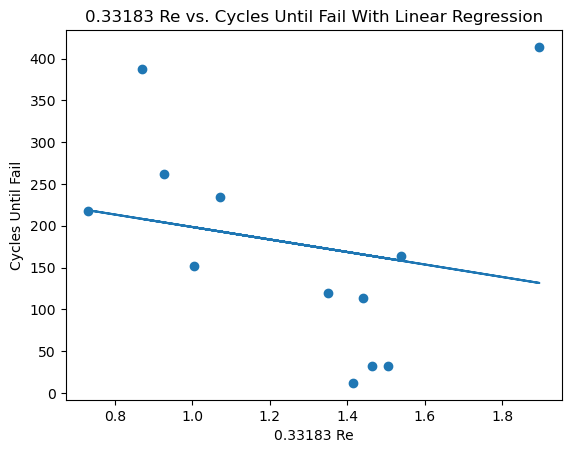

r^2 for linear Regression of 0.26261 Re vs. Cycles Until Fail is: 
0.038657285281669396


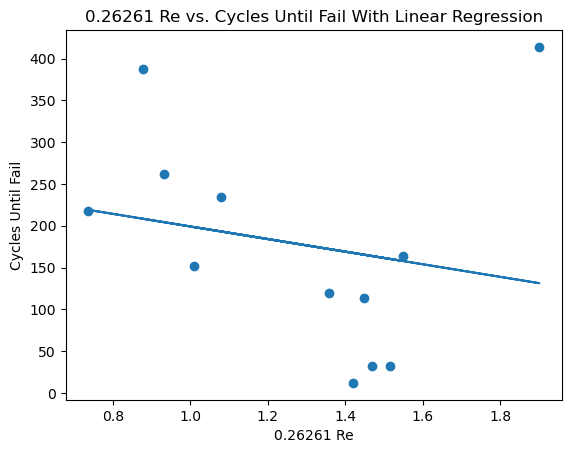

r^2 for linear Regression of 0.20791 Re vs. Cycles Until Fail is: 
0.03981023755065899


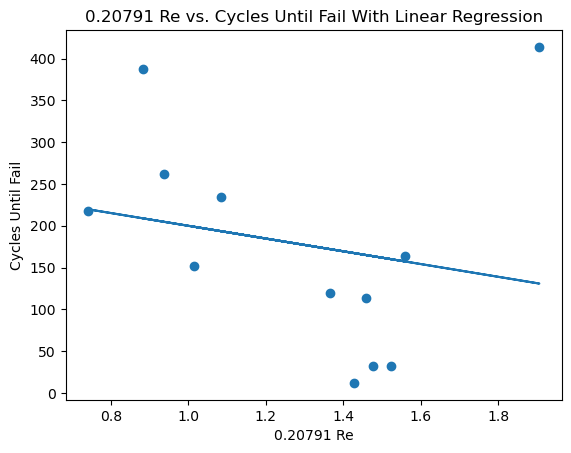

r^2 for linear Regression of 0.16452 Re vs. Cycles Until Fail is: 
0.04148546508846025


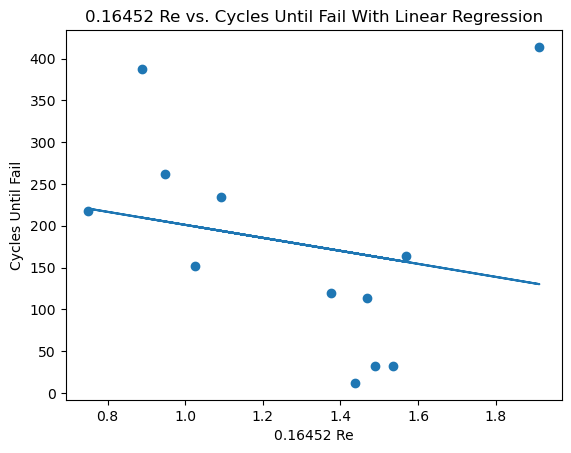

r^2 for linear Regression of 0.13007 Re vs. Cycles Until Fail is: 
0.04278484804906498


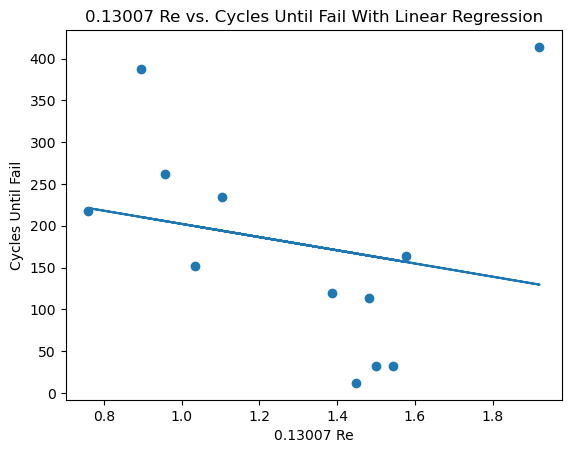

r^2 for linear Regression of 0.10309 Re vs. Cycles Until Fail is: 
0.042797270087547086


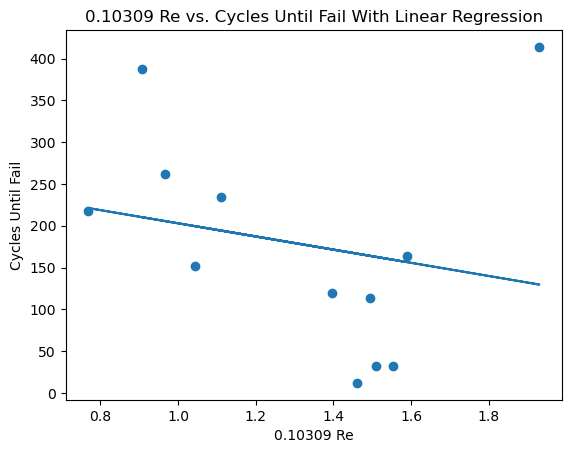

r^2 for linear Regression of 0.08153 Re vs. Cycles Until Fail is: 
0.042690172525202026


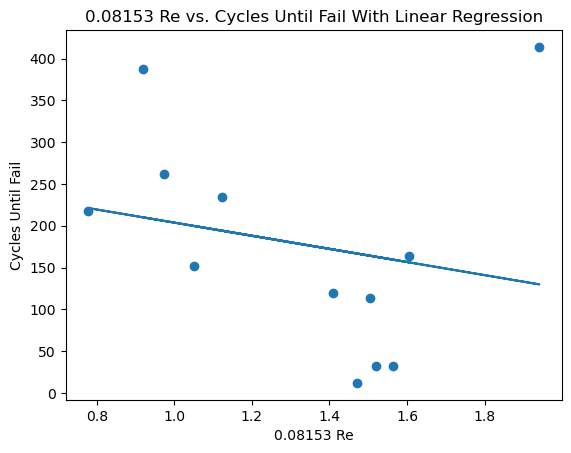

r^2 for linear Regression of 0.06443 Re vs. Cycles Until Fail is: 
0.04406650417076761


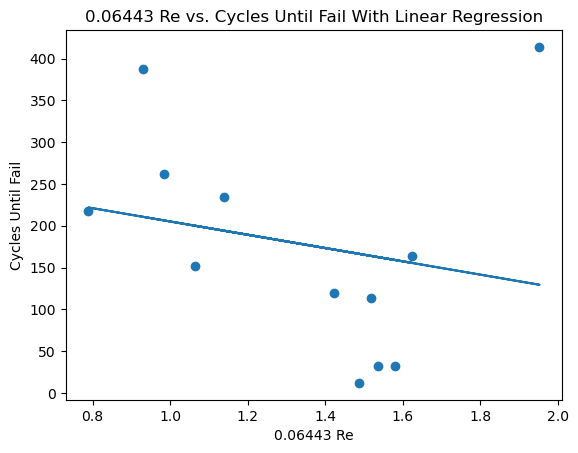

r^2 for linear Regression of 0.05102 Re vs. Cycles Until Fail is: 
0.04849398870331132


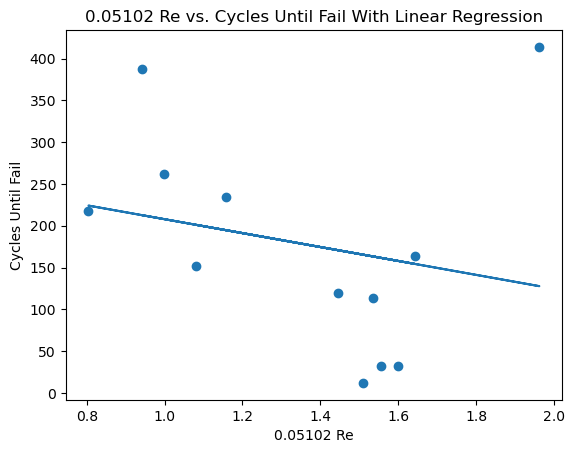

r^2 for linear Regression of 0.04042 Re vs. Cycles Until Fail is: 
0.05262786438193529


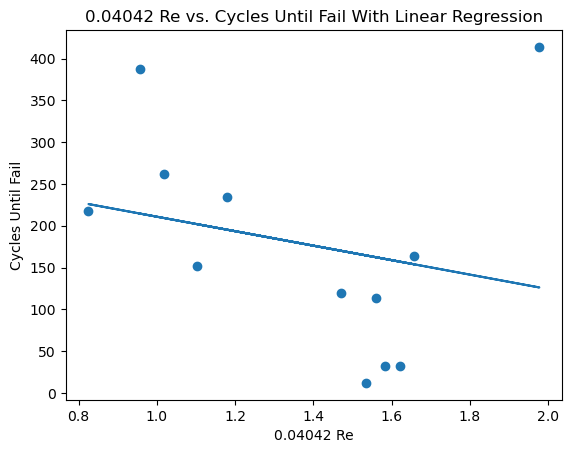

r^2 for linear Regression of 0.03192 Re vs. Cycles Until Fail is: 
0.053526328206192055


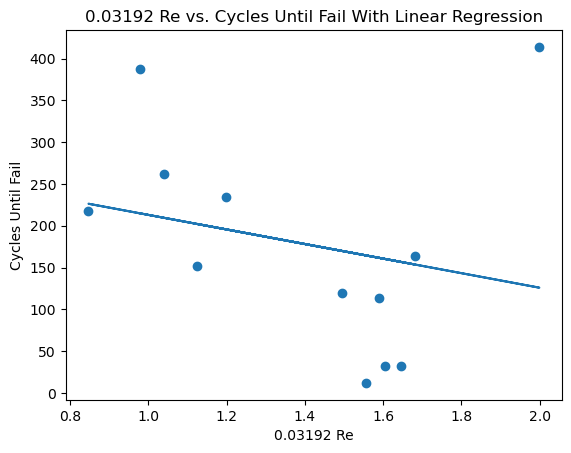

r^2 for linear Regression of 0.02528 Re vs. Cycles Until Fail is: 
0.05450593975460578


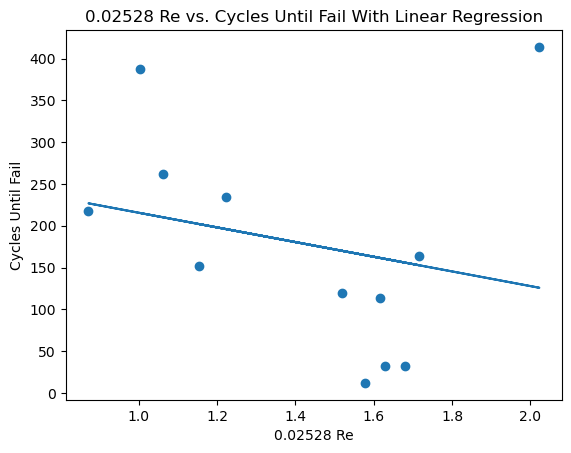

r^2 for linear Regression of 0.01999 Re vs. Cycles Until Fail is: 
0.061205104082263394


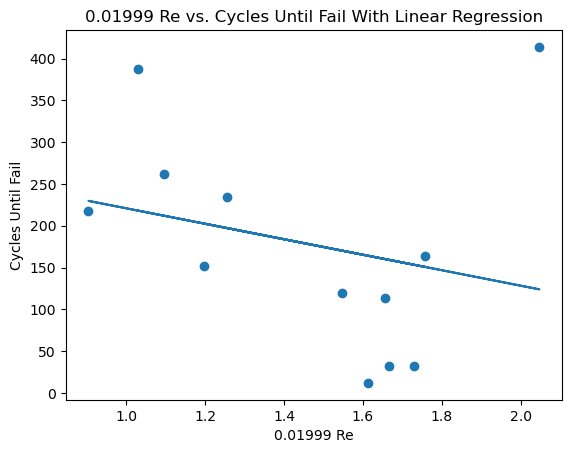

r^2 for linear Regression of 20004.453 Im vs. Cycles Until Fail is: 
0.660218584479031


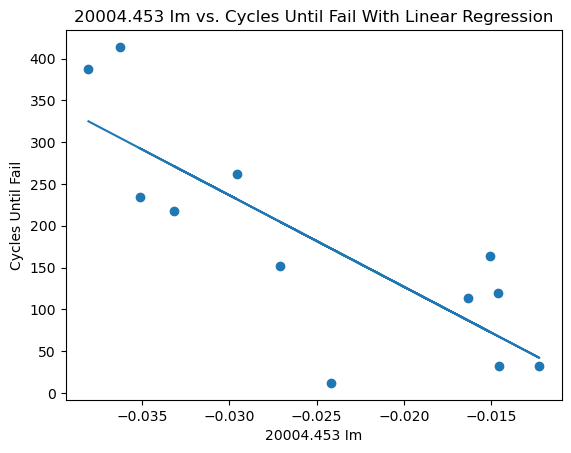

r^2 for linear Regression of 15829.126 Im vs. Cycles Until Fail is: 
0.7228668496789861


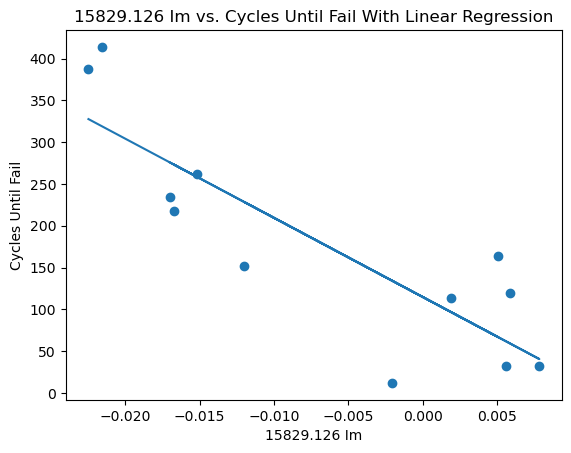

r^2 for linear Regression of 12516.703 Im vs. Cycles Until Fail is: 
0.7441353519842886


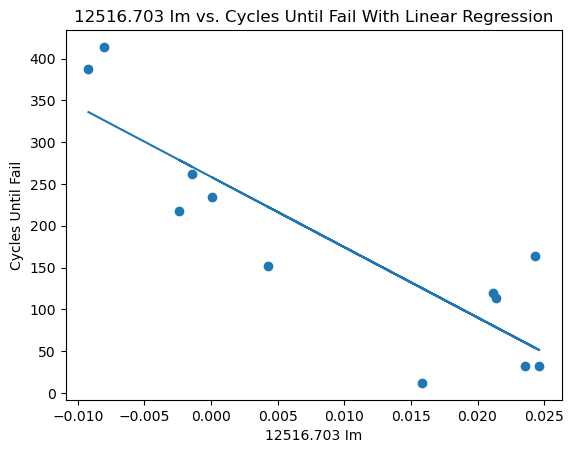

r^2 for linear Regression of 9909.4424 Im vs. Cycles Until Fail is: 
0.7670445092624103


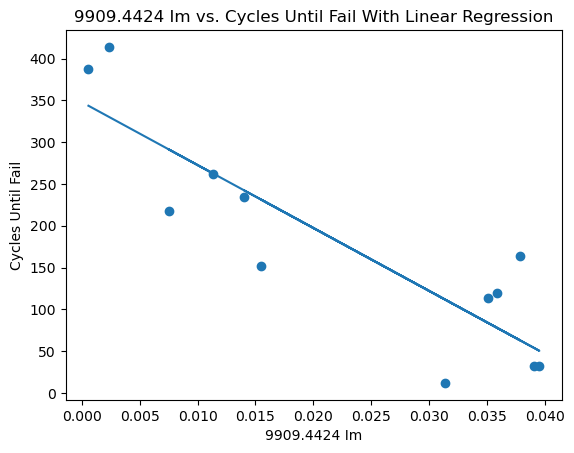

r^2 for linear Regression of 7835.48 Im vs. Cycles Until Fail is: 
0.7570946291386127


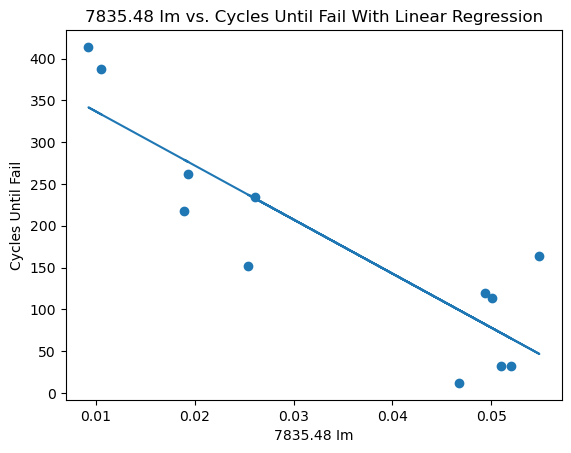

r^2 for linear Regression of 6217.2461 Im vs. Cycles Until Fail is: 
0.7709347559330537


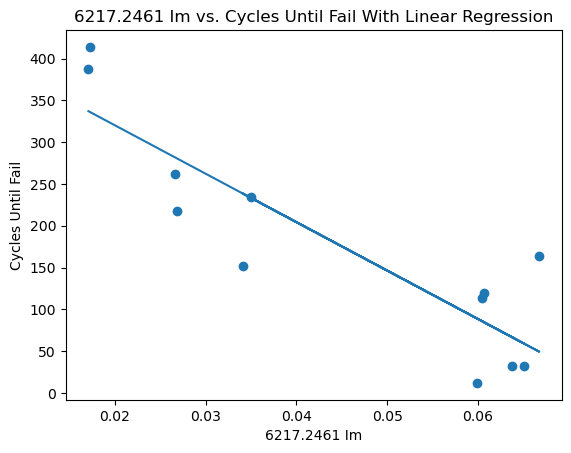

r^2 for linear Regression of 4905.291 Im vs. Cycles Until Fail is: 
0.7743826756125461


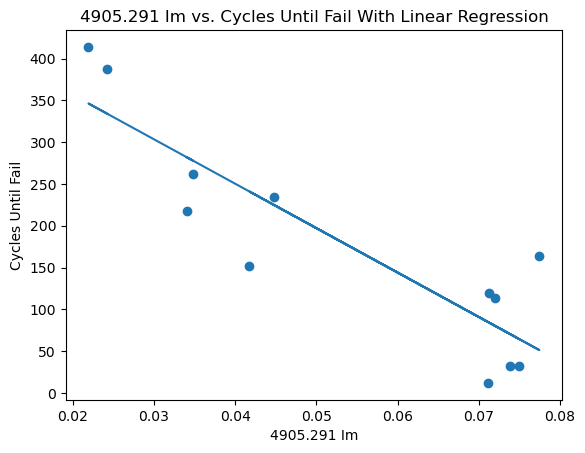

r^2 for linear Regression of 3881.2737 Im vs. Cycles Until Fail is: 
0.7800092665259086


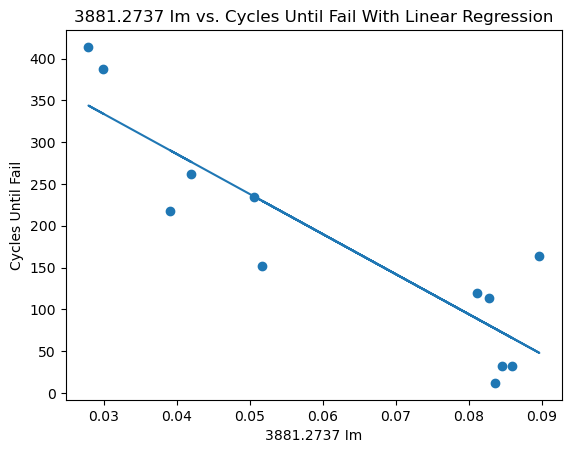

r^2 for linear Regression of 3070.9827 Im vs. Cycles Until Fail is: 
0.7872001364115891


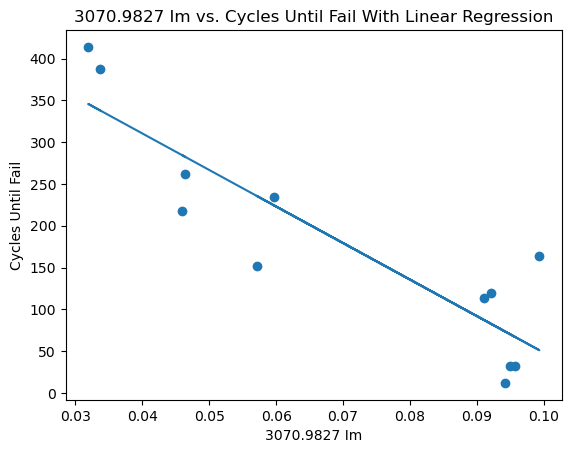

r^2 for linear Regression of 2430.7778 Im vs. Cycles Until Fail is: 
0.7858576097901123


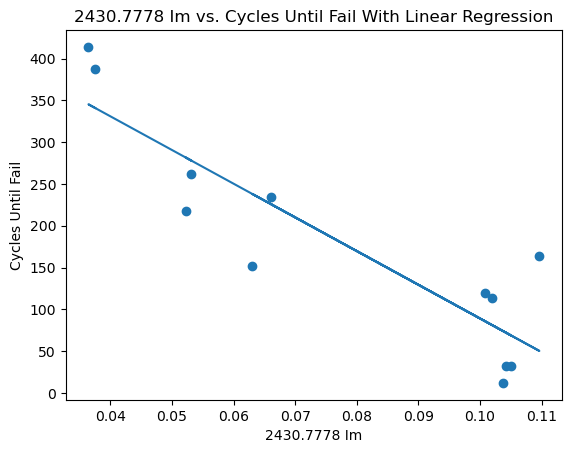

r^2 for linear Regression of 1923.1537 Im vs. Cycles Until Fail is: 
0.7791104364871495


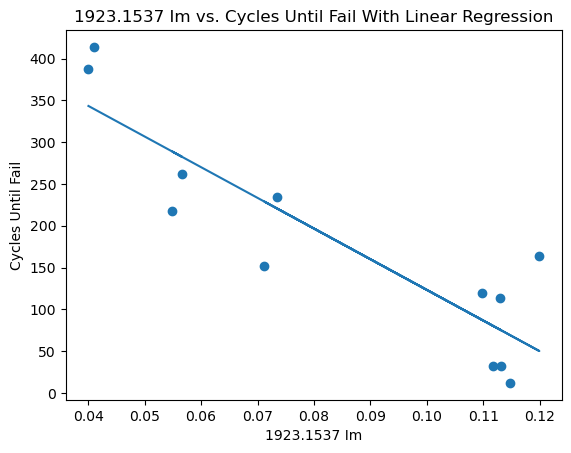

r^2 for linear Regression of 1522.4358 Im vs. Cycles Until Fail is: 
0.7722084228224259


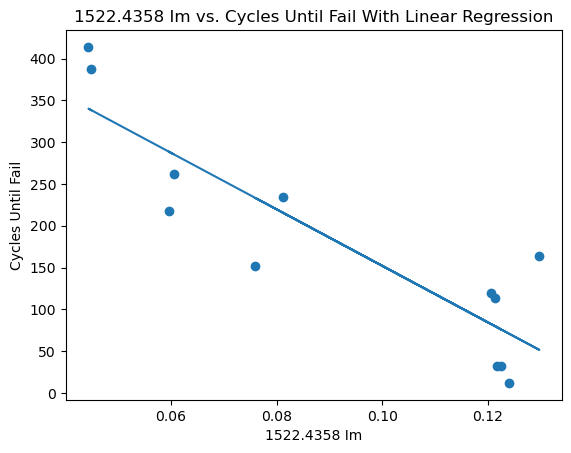

r^2 for linear Regression of 1203.8446 Im vs. Cycles Until Fail is: 
0.778059929946696


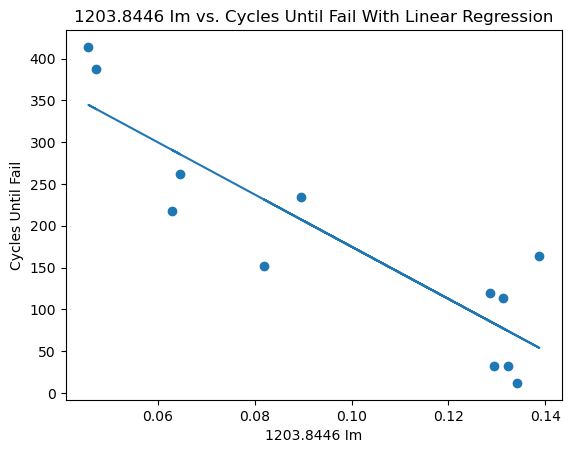

r^2 for linear Regression of 952.86591 Im vs. Cycles Until Fail is: 
0.7849337415351687


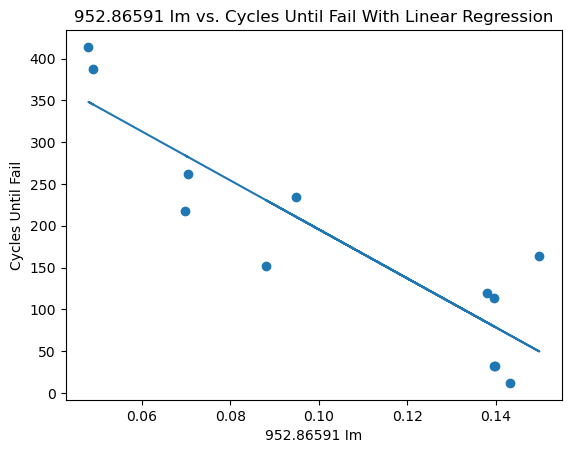

r^2 for linear Regression of 754.27557 Im vs. Cycles Until Fail is: 
0.7861505000981273


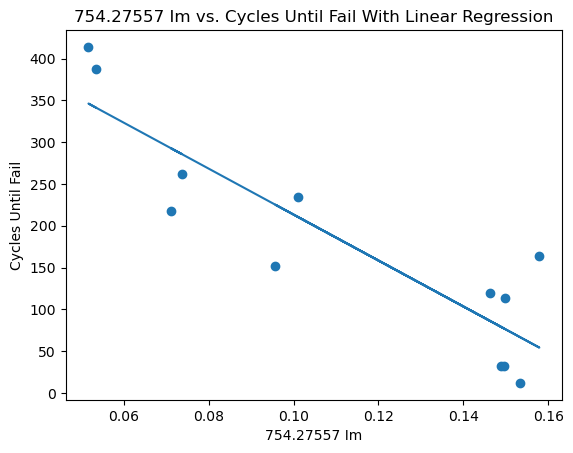

r^2 for linear Regression of 596.71857 Im vs. Cycles Until Fail is: 
0.7880783976782315


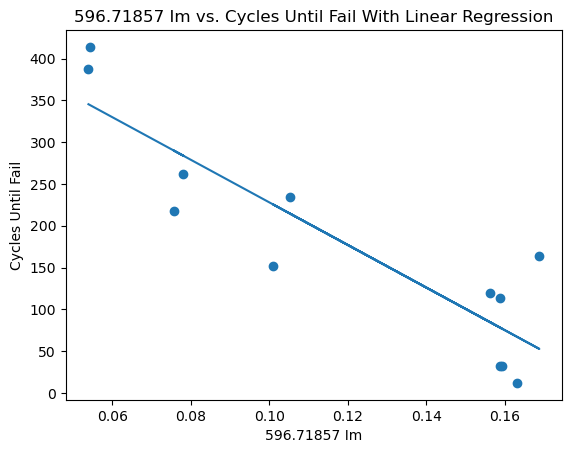

r^2 for linear Regression of 471.96338 Im vs. Cycles Until Fail is: 
0.777120510004167


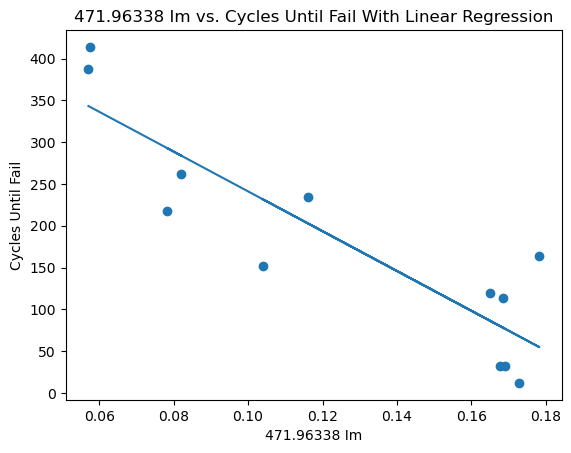

r^2 for linear Regression of 373.20856 Im vs. Cycles Until Fail is: 
0.781376988711469


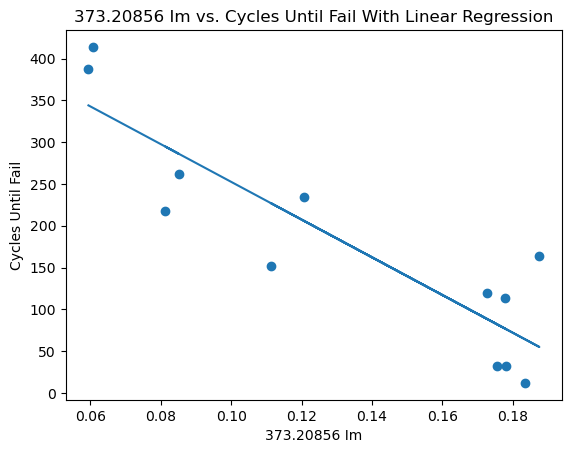

r^2 for linear Regression of 295.47278 Im vs. Cycles Until Fail is: 
0.784485391879478


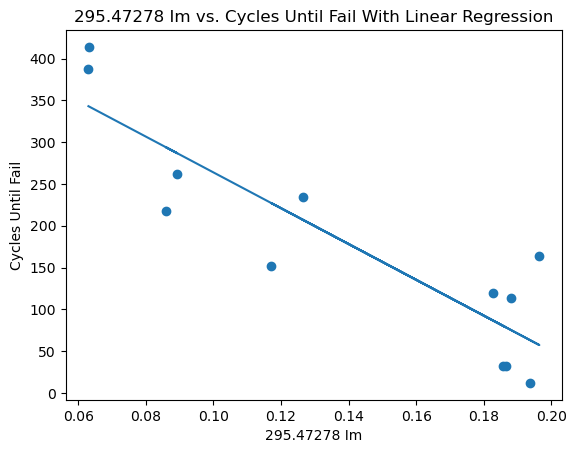

r^2 for linear Regression of 233.87738 Im vs. Cycles Until Fail is: 
0.77747461897184


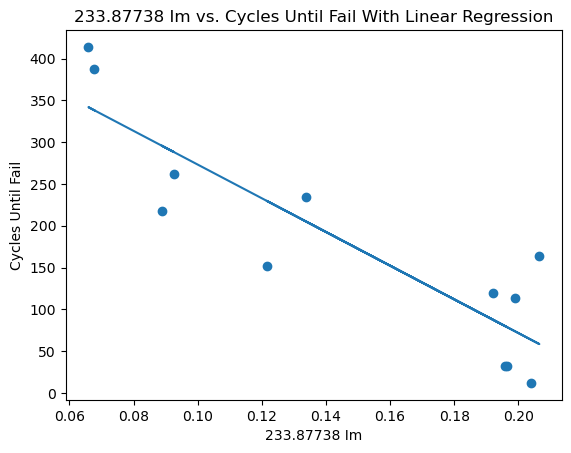

r^2 for linear Regression of 185.05922 Im vs. Cycles Until Fail is: 
0.7775779482355966


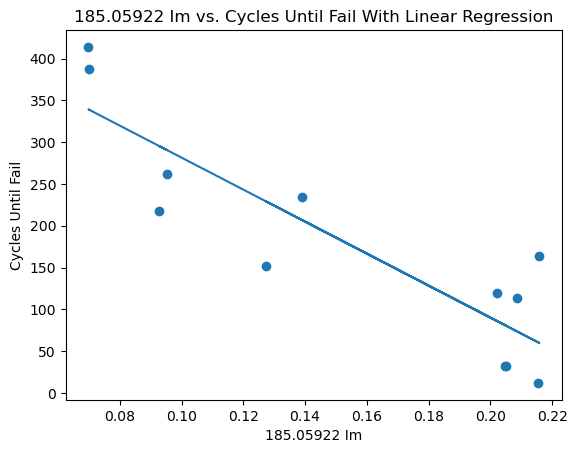

r^2 for linear Regression of 146.35823 Im vs. Cycles Until Fail is: 
0.7759255055092916


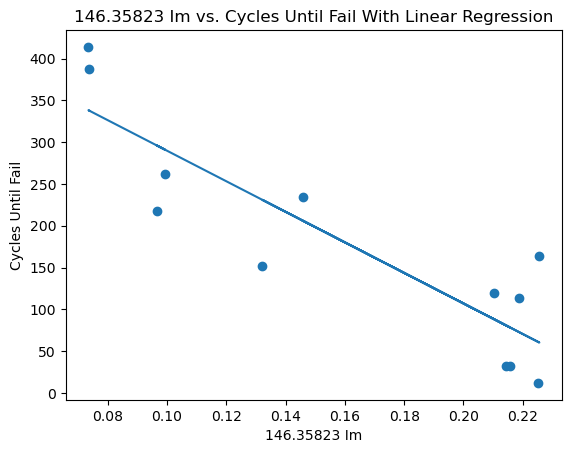

r^2 for linear Regression of 115.77804 Im vs. Cycles Until Fail is: 
0.7715911864441904


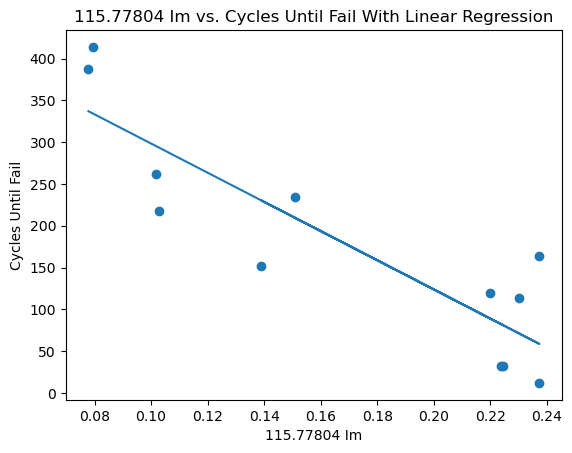

r^2 for linear Regression of 91.6721 Im vs. Cycles Until Fail is: 
0.7748460359123966


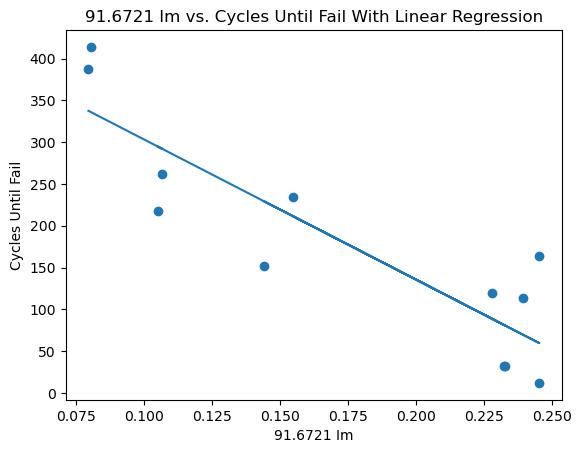

r^2 for linear Regression of 72.51701 Im vs. Cycles Until Fail is: 
0.777770737435532


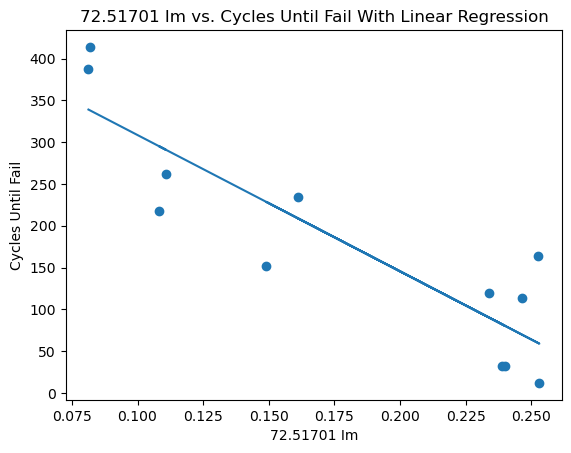

r^2 for linear Regression of 57.36816 Im vs. Cycles Until Fail is: 
0.7827737364579592


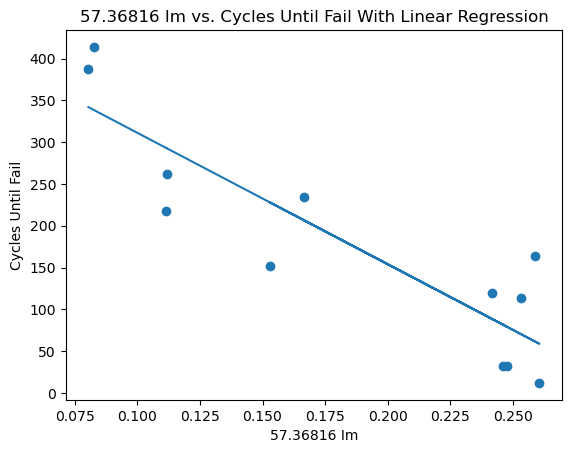

r^2 for linear Regression of 45.3629 Im vs. Cycles Until Fail is: 
0.7914496308155556


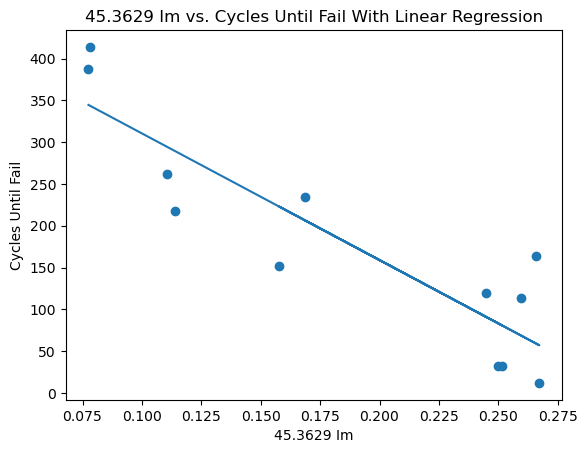

r^2 for linear Regression of 35.93134 Im vs. Cycles Until Fail is: 
0.7938242457750276


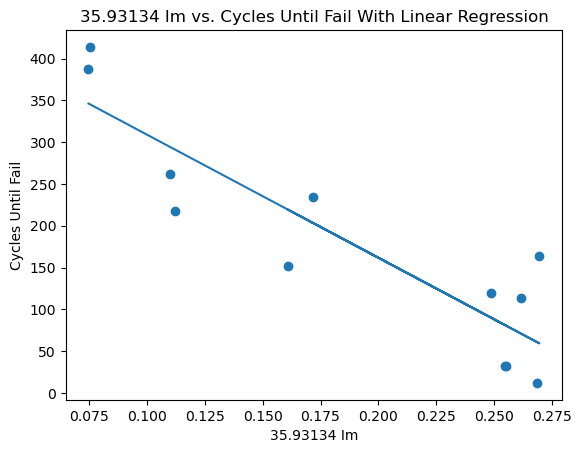

r^2 for linear Regression of 28.40909 Im vs. Cycles Until Fail is: 
0.7995460871848303


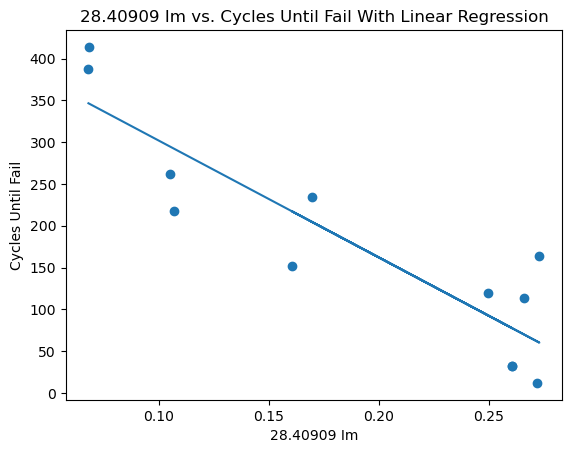

r^2 for linear Regression of 22.48202 Im vs. Cycles Until Fail is: 
0.7930561644776482


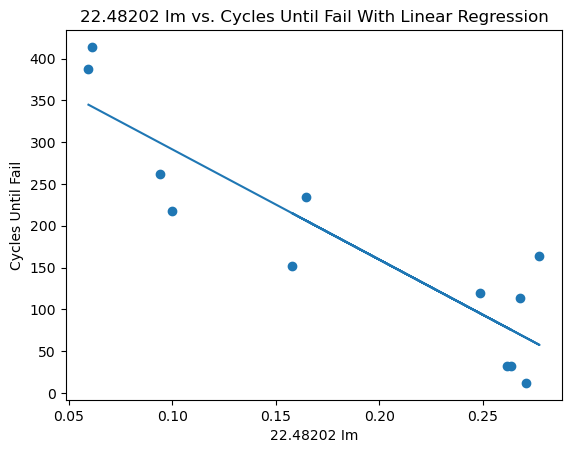

r^2 for linear Regression of 17.79613 Im vs. Cycles Until Fail is: 
0.7849124810613789


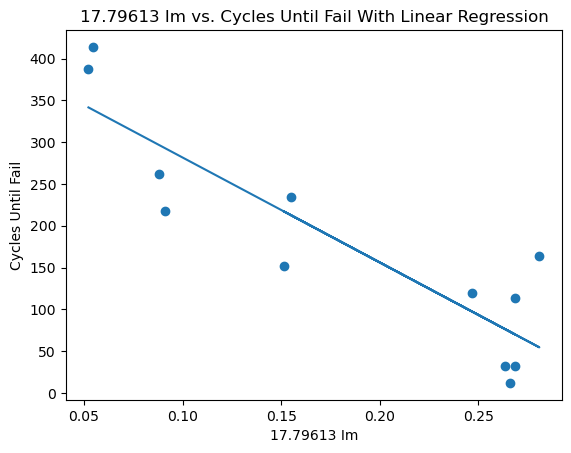

r^2 for linear Regression of 14.06813 Im vs. Cycles Until Fail is: 
0.7717509744725684


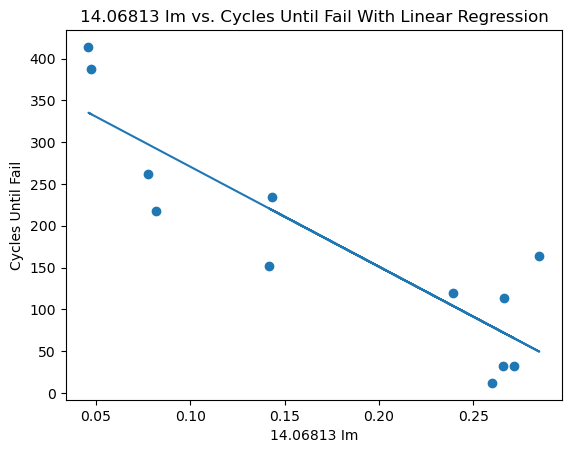

r^2 for linear Regression of 11.1448 Im vs. Cycles Until Fail is: 
0.7501727732018474


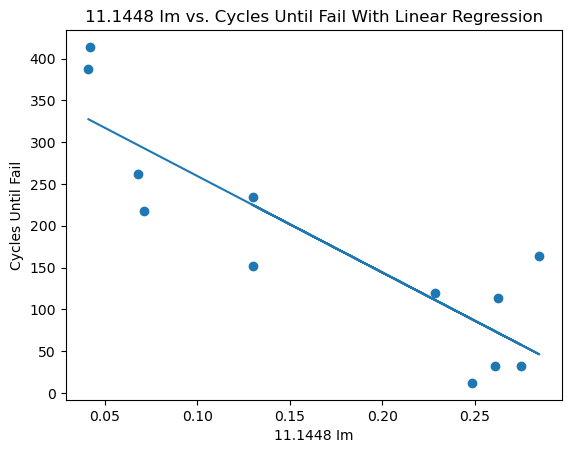

r^2 for linear Regression of 8.81772 Im vs. Cycles Until Fail is: 
0.7295935673963517


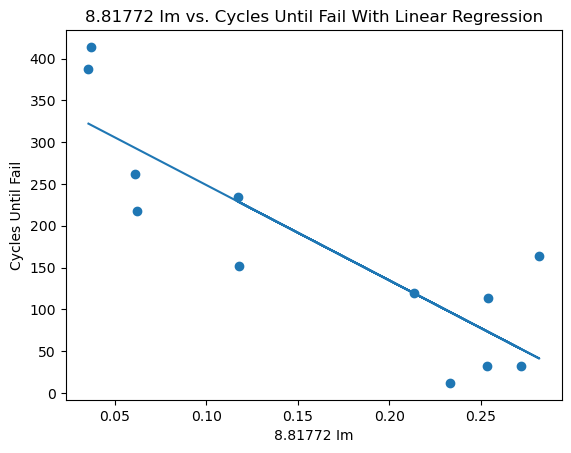

r^2 for linear Regression of 6.97545 Im vs. Cycles Until Fail is: 
0.7140345126842665


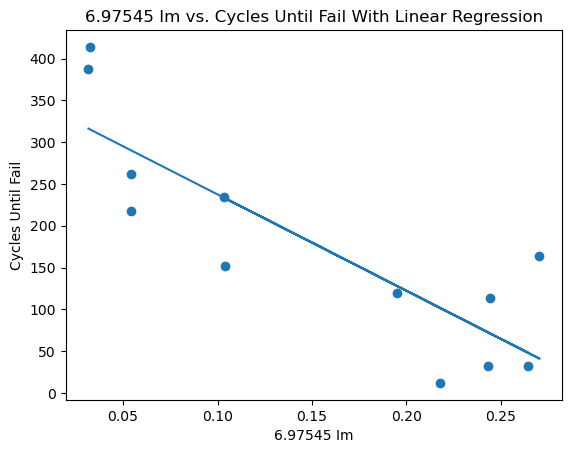

r^2 for linear Regression of 5.5173 Im vs. Cycles Until Fail is: 
0.6833427737934517


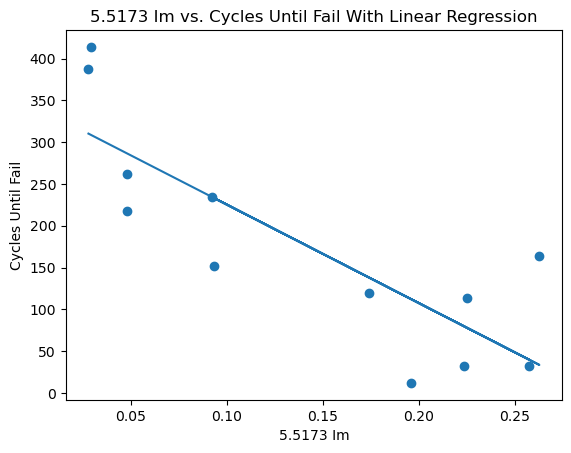

r^2 for linear Regression of 4.36941 Im vs. Cycles Until Fail is: 
0.6711454454268396


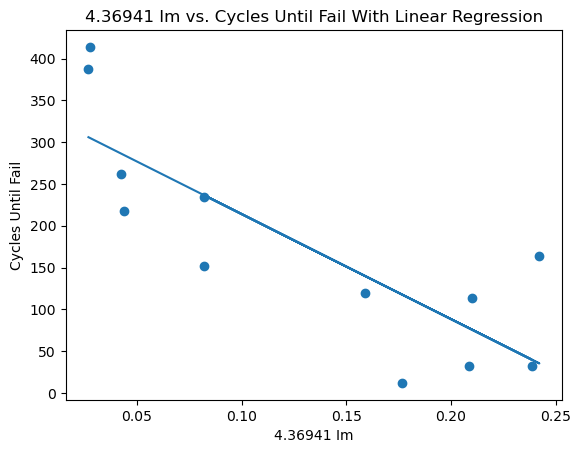

r^2 for linear Regression of 3.45686 Im vs. Cycles Until Fail is: 
0.6507361767010877


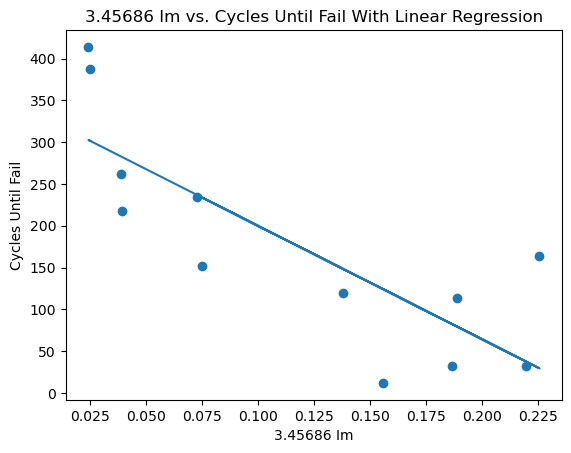

r^2 for linear Regression of 2.73547 Im vs. Cycles Until Fail is: 
0.6478887173657402


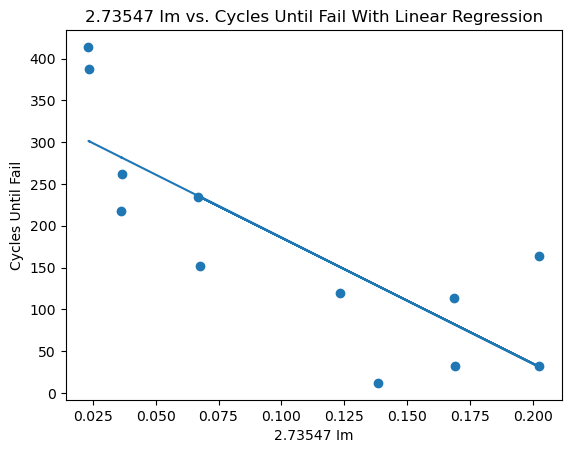

r^2 for linear Regression of 2.16054 Im vs. Cycles Until Fail is: 
0.6451745531531338


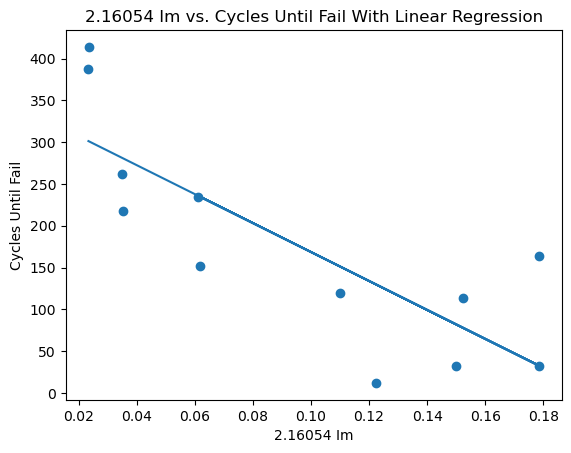

r^2 for linear Regression of 1.70952 Im vs. Cycles Until Fail is: 
0.634882749733309


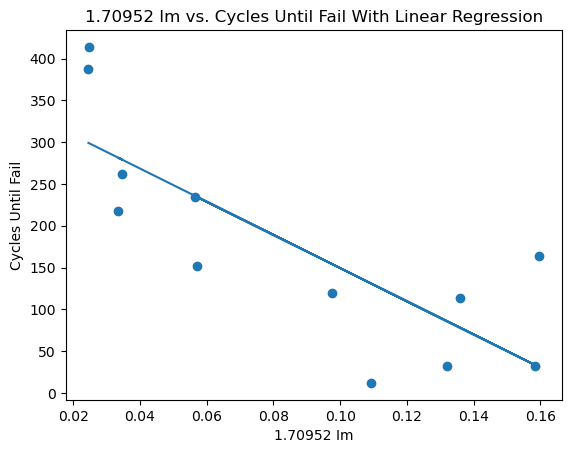

r^2 for linear Regression of 1.35352 Im vs. Cycles Until Fail is: 
0.6338584517060929


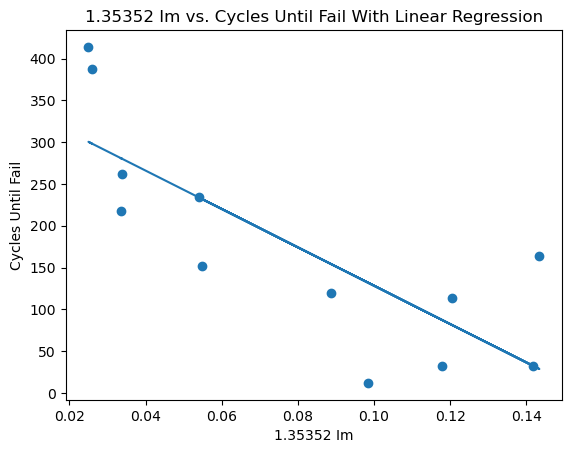

r^2 for linear Regression of 1.07079 Im vs. Cycles Until Fail is: 
0.6448384238265203


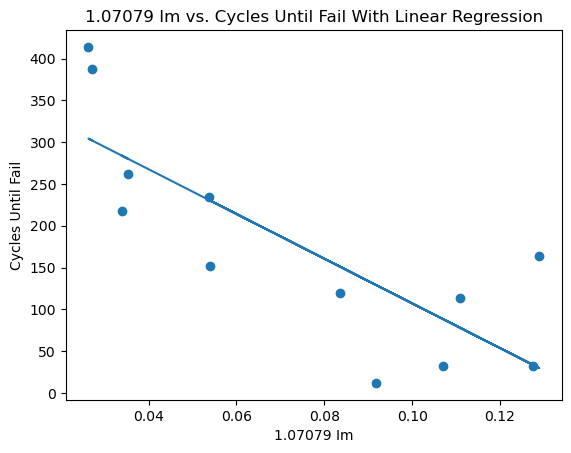

r^2 for linear Regression of 0.84734 Im vs. Cycles Until Fail is: 
0.6574479502463287


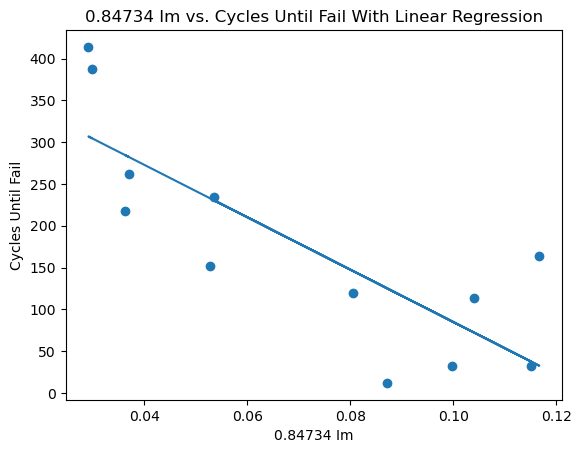

r^2 for linear Regression of 0.67072 Im vs. Cycles Until Fail is: 
0.6632801311578256


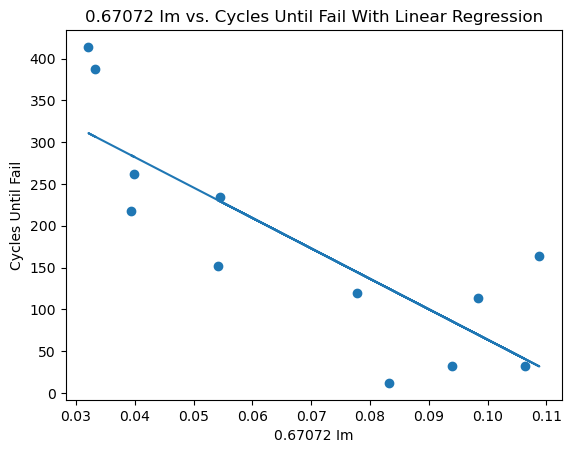

r^2 for linear Regression of 0.53067 Im vs. Cycles Until Fail is: 
0.6491989506685913


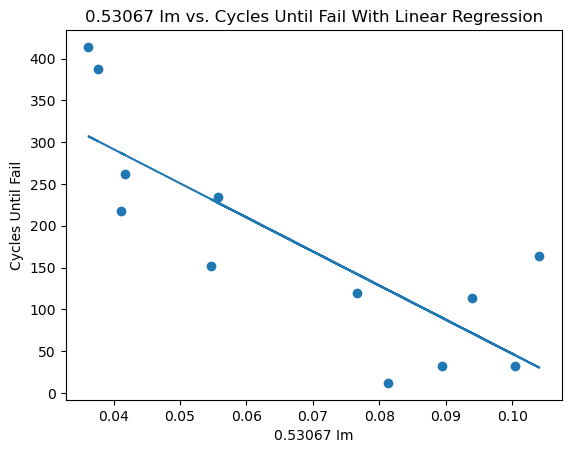

r^2 for linear Regression of 0.41976 Im vs. Cycles Until Fail is: 
0.6668690259915471


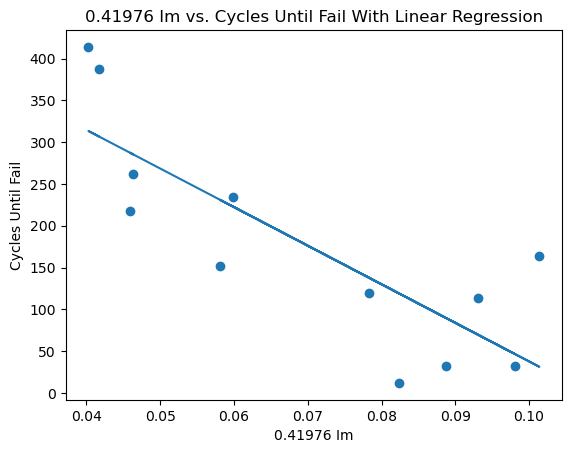

r^2 for linear Regression of 0.33183 Im vs. Cycles Until Fail is: 
0.6950980158757459


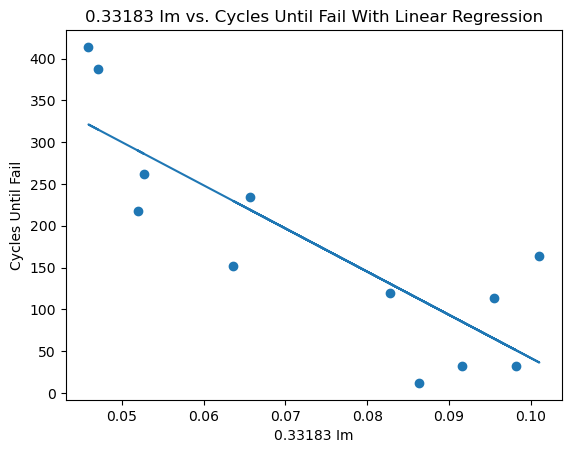

r^2 for linear Regression of 0.26261 Im vs. Cycles Until Fail is: 
0.7139983724267693


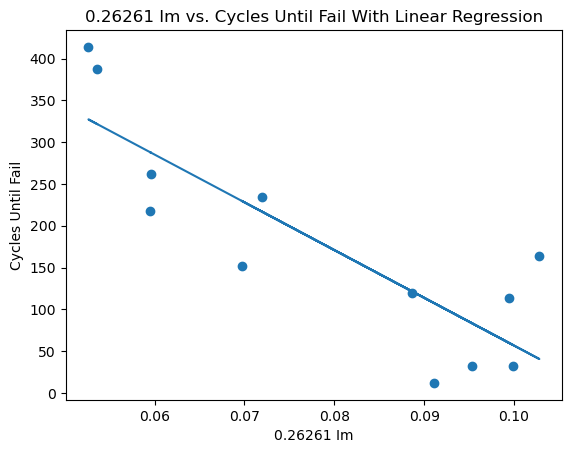

r^2 for linear Regression of 0.20791 Im vs. Cycles Until Fail is: 
0.698053764528337


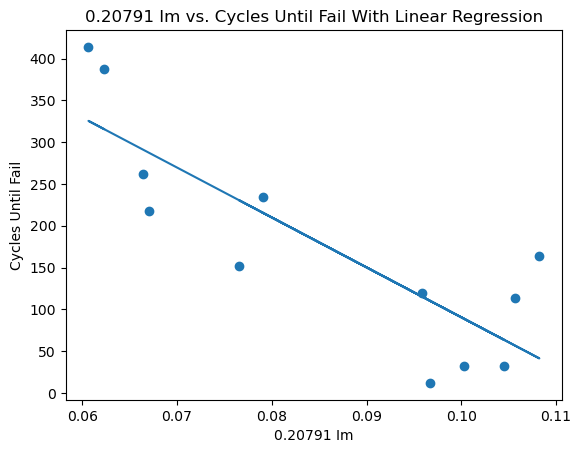

r^2 for linear Regression of 0.16452 Im vs. Cycles Until Fail is: 
0.704409877288068


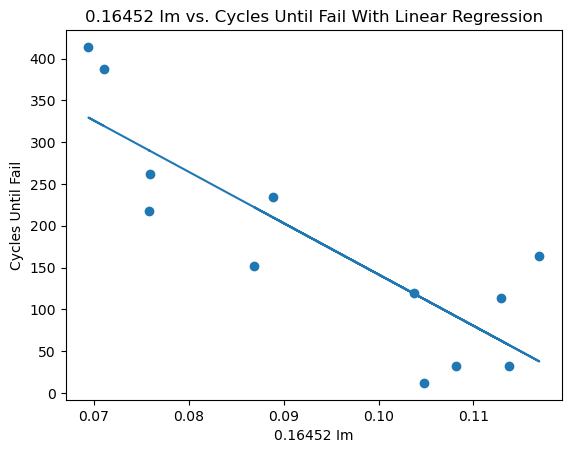

r^2 for linear Regression of 0.13007 Im vs. Cycles Until Fail is: 
0.7453961137199088


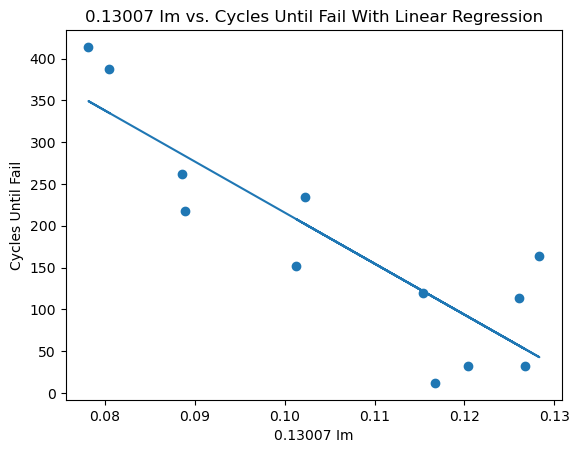

r^2 for linear Regression of 0.10309 Im vs. Cycles Until Fail is: 
0.7897288133439992


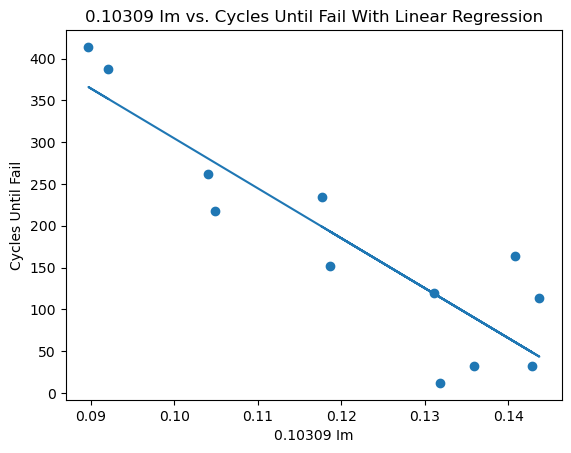

r^2 for linear Regression of 0.08153 Im vs. Cycles Until Fail is: 
0.7796099975964936


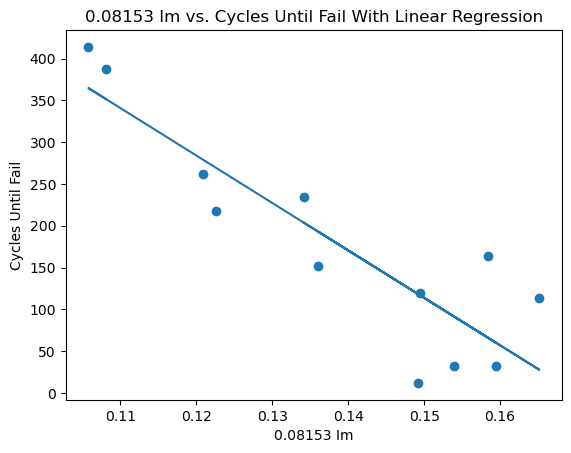

r^2 for linear Regression of 0.06443 Im vs. Cycles Until Fail is: 
0.7450482840081545


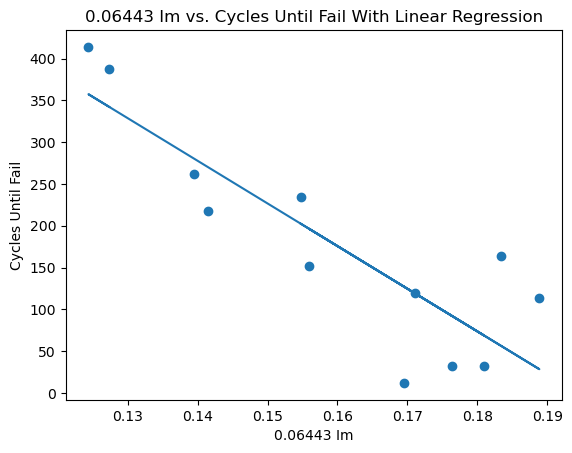

r^2 for linear Regression of 0.05102 Im vs. Cycles Until Fail is: 
0.7144021564280392


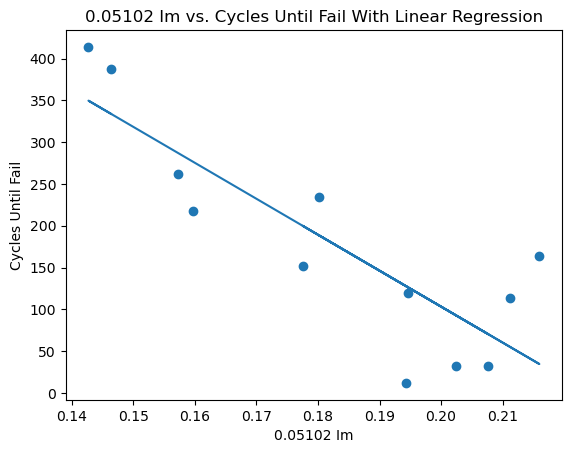

r^2 for linear Regression of 0.04042 Im vs. Cycles Until Fail is: 
0.7519810831719623


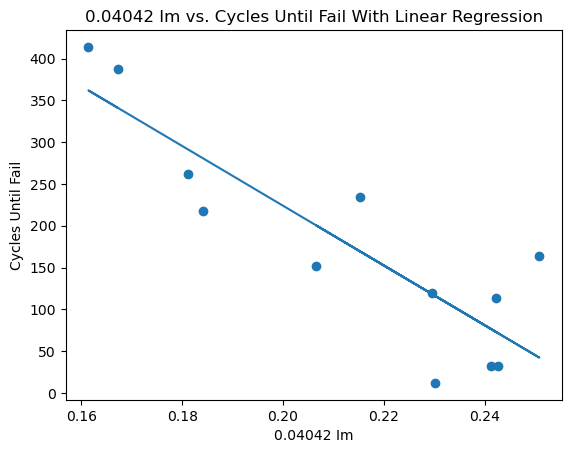

r^2 for linear Regression of 0.03192 Im vs. Cycles Until Fail is: 
0.7941645127547509


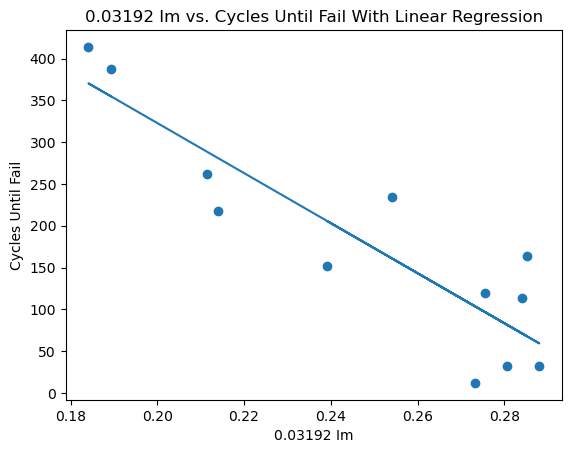

r^2 for linear Regression of 0.02528 Im vs. Cycles Until Fail is: 
0.7865319075075222


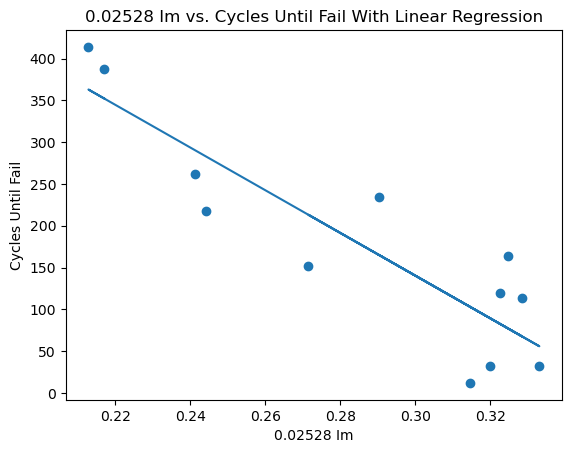

r^2 for linear Regression of 0.01999 Im vs. Cycles Until Fail is: 
0.7670382922526258


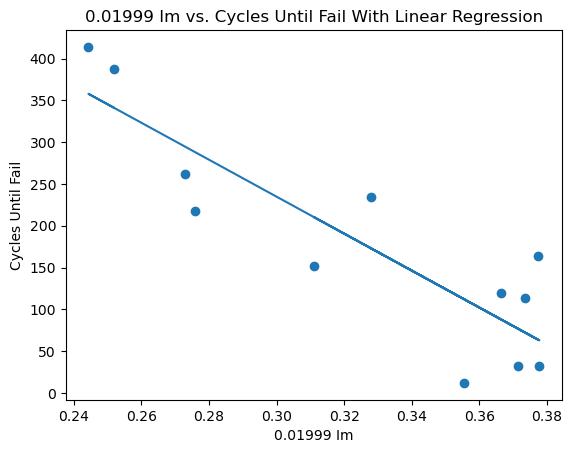

In [79]:
cols=df.columns.to_list()
for i in range(5,125):
    Plot_LR(df_1,cols[i],'Cycles Until Fail')

In [80]:
cols=df.columns.to_list()
for i in range(5,125):
    r2=Return_Lin_r2(df_1,cols[i],'Cycles Until Fail')
    print(str(i)+' - '+cols[i]+' : '+str(r2))

5 - 20004.453 Re : 0.504178832079568
6 - 15829.126 Re : 0.5028996458973473
7 - 12516.703 Re : 0.4985564569146866
8 - 9909.4424 Re : 0.494942772515598
9 - 7835.48 Re : 0.4898633302002737
10 - 6217.2461 Re : 0.48494669348251723
11 - 4905.291 Re : 0.48019825106331787
12 - 3881.2737 Re : 0.47395759712859553
13 - 3070.9827 Re : 0.46604369500970066
14 - 2430.7778 Re : 0.4590668761840825
15 - 1923.1537 Re : 0.4510026836264798
16 - 1522.4358 Re : 0.44313499009142066
17 - 1203.8446 Re : 0.431099238450215
18 - 952.86591 Re : 0.41875087082438023
19 - 754.27557 Re : 0.40863624455332964
20 - 596.71857 Re : 0.3935048573921753
21 - 471.96338 Re : 0.3786695510677582
22 - 373.20856 Re : 0.3619129745897726
23 - 295.47278 Re : 0.3456018848821653
24 - 233.87738 Re : 0.32652990794460746
25 - 185.05922 Re : 0.3055533504148318
26 - 146.35823 Re : 0.28310917279610154
27 - 115.77804 Re : 0.260925661081358
28 - 91.6721 Re : 0.2353530829242129
29 - 72.51701 Re : 0.21266742083232384
30 - 57.36816 Re : 0.189339344

In [81]:
cols=df.columns.to_list()
Re_i=[]
Re_lab=[]
Re_r2=[]
Im_i=[]
Im_lab=[]
Im_r2=[]
for i in range(5,65):
    r2=Return_Lin_r2(df_1,cols[i],'Cycles Until Fail')
    Re_i.append(i)
    Re_lab.append(cols[i])
    Re_r2.append(r2)
for i in range(65,125):
    r2=Return_Lin_r2(df_1,cols[i],'Cycles Until Fail')
    Im_i.append(i)
    Im_lab.append(cols[i])
    Im_r2.append(r2)

In [82]:
#Create a dictionary which will become a dataframe.
r2_dict = {'Index': Im_i,'Label': Im_lab,'r2':Im_r2}
# Create DataFrame
r2_df = pd.DataFrame(r2_dict)

In [83]:
r2_df.sort_values(by=['r2'],ascending=False,ignore_index=True)

Index         Label        r2
0      93   28.40909 Im  0.799546
1     122    0.03192 Im  0.794165
2      92   35.93134 Im  0.793824
3      94   22.48202 Im  0.793056
4      91    45.3629 Im  0.791450
5     117    0.10309 Im  0.789729
6      80  596.71857 Im  0.788078
7      73  3070.9827 Im  0.787200
8     123    0.02528 Im  0.786532
9      79  754.27557 Im  0.786151
10     74  2430.7778 Im  0.785858
11     78  952.86591 Im  0.784934
12     95   17.79613 Im  0.784912
13     83  295.47278 Im  0.784485
14     90   57.36816 Im  0.782774
15     82  373.20856 Im  0.781377
16     72  3881.2737 Im  0.780009
17    118    0.08153 Im  0.779610
18     75  1923.1537 Im  0.779110
19     77  1203.8446 Im  0.778060
20     89   72.51701 Im  0.777771
21     85  185.05922 Im  0.777578
22     84  233.87738 Im  0.777475
23     81  471.96338 Im  0.777121
24     86  146.35823 Im  0.775926
25     88    91.6721 Im  0.774846
26     71   4905.291 Im  0.774383
27     76  1522.4358 Im  0.772208
28     96   14.06813 Im  0.771751
29     87  115.77804 Im  0.771591
30     70  6217.2461 Im  0.770935
31     68  9909.4424 Im  0.767045
32    124    0.01999 Im  0.767038
33     69    7835.48 Im  0.757095
34    121    0.04042 Im  0.751981
35     97    11.1448 Im  0.750173
36    116    0.13007 Im  0.745396
37    119    0.06443 Im  0.745048
38     67  12516.703 Im  0.744135
39     98    8.81772 Im  0.729594
40     66  15829.126 Im  0.722867
41    120    0.05102 Im  0.714402
42     99    6.97545 Im  0.714035
43    113    0.26261 Im  0.713998
44    115    0.16452 Im  0.704410
45    114    0.20791 Im  0.698054
46    112    0.33183 Im  0.695098
47    100     5.5173 Im  0.683343
48    101    4.36941 Im  0.671145
49    111    0.41976 Im  0.666869
50    109    0.67072 Im  0.663280
51     65  20004.453 Im  0.660219
52    108    0.84734 Im  0.657448
53    102    3.45686 Im  0.650736
54    110    0.53067 Im  0.649199
55    103    2.73547 Im  0.647889
56    104    2.16054 Im  0.645175
57    107    1.07079 Im  0.644838
58    105    1.70952 Im  0.634883
59    106    1.35352 Im  0.633858

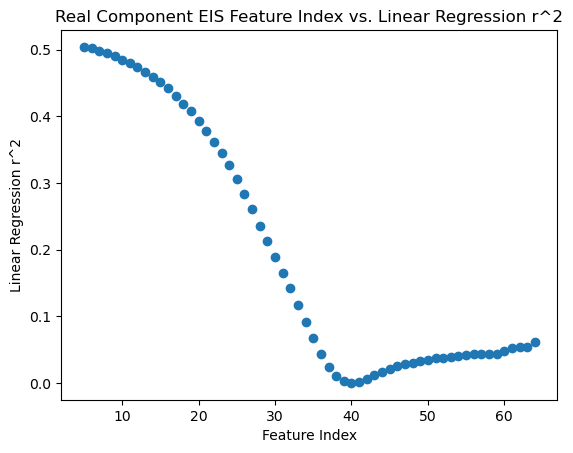

In [84]:
plt.scatter(Re_i,Re_r2)
plt.xlabel('Feature Index')
plt.ylabel('Linear Regression r^2')
plt.title('Real Component EIS Feature Index vs. Linear Regression r^2')
plt.show()

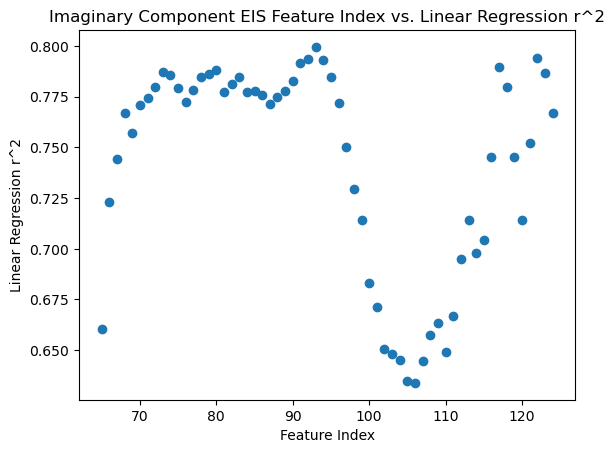

In [85]:
plt.scatter(Im_i,Im_r2)
plt.xlabel('Feature Index')
plt.ylabel('Linear Regression r^2')
plt.title('Imaginary Component EIS Feature Index vs. Linear Regression r^2')
plt.show()

In [86]:
Return_Lin_r2(df_1,'8.81772 Im','Cycles Until Fail')

0.7295935673963517

r^2 for linear Regression of 28.40909 Im vs. Cycles Until Fail is: 
0.7995460871848303


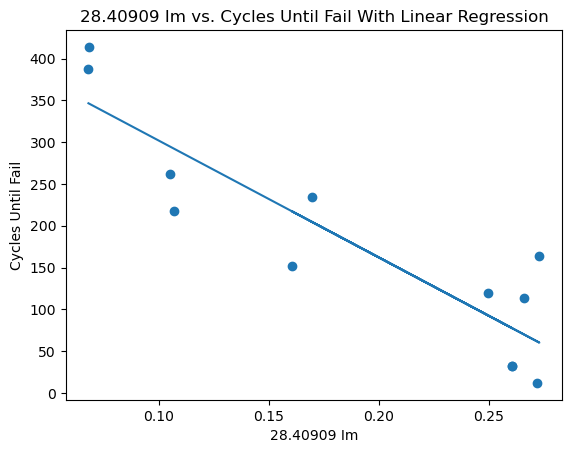

In [87]:
Plot_LR(df_1,'28.40ttf909 Im','Cycles Until Fail')

r^2 for linear Regression of 0.03192 Im vs. Cycles Until Fail is: 
0.7941645127547509


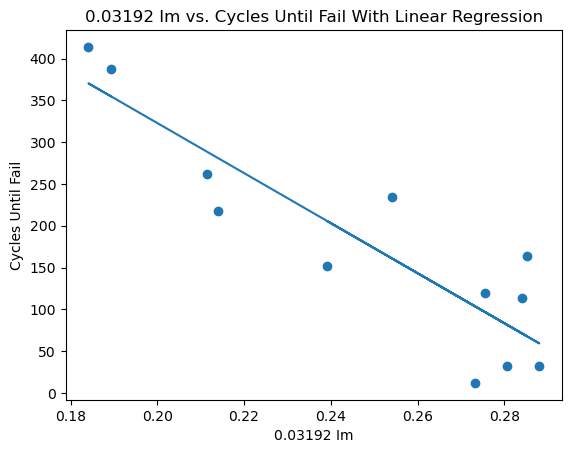

In [88]:
Plot_LR(df_1,'0.03192 Im','Cycles Until Fail')

r^2 for linear Regression of 2.73547 Im vs. Cycles Until Fail is: 
0.6478887173657402


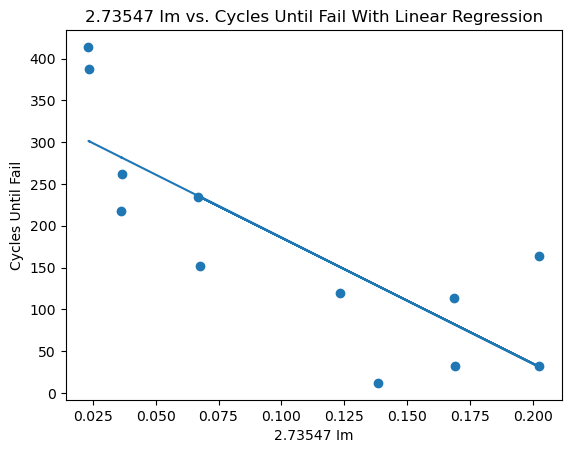

In [89]:
Plot_LR(df_1,'2.73547 Im','Cycles Until Fail')